# Time Series Forecasting using Python 
([Ref](https://courses.analyticsvidhya.com/courses/take/creating-time-series-forecast-using-python/texts/10561479-introduction-to-the-course). Errors are corrected.)

## Introduction to Time Series
* *Definition*:<br>
    Time Series is generally data which is collected over time and is **dependent** on it. Not every data collected with respect to time represents a time series. The observations have to be **dependent** on time. 
    
* *Components of a Time Series:* <br>
    1. Trend: Trend is a general direction in which something is developing or changing. 
    2. Seasonality: Seasonality is the pattern is repeating at regular time interval. Any predictable change or pattern in a time series that recurs or repeats over a specific time period can be saidd to be seasonality. <br>
    Difference between a time series and regression problem: <br>
        * The main difference is that a time series is time depenent. So the basic assumption of a linear regression model that the observations are indepdendent doesn't hold in this case.
        * Along with in increasing or decreasing trend, most time series have some form of seasonality trends, i.e. variations specific to a particular time frame. 
        
* *Techniques for Time Series Forecasting:* <br>
    1. **Naive approach:** Forecast the next day point as current day point.
    2. **Moving Average:** Take the average of past days (like 30) into consideration to predict as the current point.
    3. **Simple Exponential Smoothing:** Assign larger weigths to more recent observations than to observations from distant past. The weights decrease exponentially as observations come from further in the past.
    4. **Holt's Linear Trend Model:** with trend but no seasonality.
    5. **Holt Winter's Model:** Take both trend and seasonality into consideration.
    6. **ARIMA Model (Auto Regressive Integrated Moving Average):** Aim to describe correlations in time series.
    7. **SARIMAX Model:**: SARIMAX model takes into account the seasonality of the time series.  

## Understanding Problem Statements and Datasets
**Problem**: forecast the traffic (passenger count) on JetRail for the next 7 months

### 1. Hypothesis Generation
Hypothesis generation is the process of listing out all the possible factors that can affect the outcome. Hypothesis generation is done before having a look at the data in order to avoid any bias that may result after the observation.
* There will be an increase in the traffic as the years pass by.
* The traffic will be high from May to October.
* Traffic on weekdays will be more as compared to weekends/holidays.
* Traffic during the peak hours will be high.

### 2. Loading the Data

In [1]:
# Import the necessary packages
import pandas as pd
import numpy as np # for mathematical calculations
import matplotlib.pyplot as plt # for plotting graphs
from datetime import datetime # to access datetime

%matplotlib inline
import warnings
warnings.filterwarnings('ignore') # to ignore the warnings

In [2]:
# Read the data
train = pd.read_csv('./data/Train_SU63ISt.csv')
test = pd.read_csv('./data/Test_0qrQsBZ.csv')

# Make a copy of the training and test data so we don't lose the original dataset
train_original = train.copy()
test_original = test.copy()

### 3. Dataset Structure and Content
Let's dive deeper and have a look at the dataset.

In [3]:
# Look at features in the training and test datasets
print(train.columns)
print(test.columns)

Index(['ID', 'Datetime', 'Count'], dtype='object')
Index(['ID', 'Datetime'], dtype='object')


In [4]:
# Look at the data types of each feature
print(train.dtypes)
print(test.dtypes)

ID           int64
Datetime    object
Count        int64
dtype: object
ID           int64
Datetime    object
dtype: object


In [5]:
# Check the shape of the datasets
print(train.shape)
print(test.shape)

(18288, 3)
(5112, 2)


In [6]:
# Look at the first 5 rows of datasets
print(train.head())
print(test.head())

   ID          Datetime  Count
0   0  25-08-2012 00:00      8
1   1  25-08-2012 01:00      2
2   2  25-08-2012 02:00      6
3   3  25-08-2012 03:00      2
4   4  25-08-2012 04:00      2
      ID          Datetime
0  18288  26-09-2014 00:00
1  18289  26-09-2014 01:00
2  18290  26-09-2014 02:00
3  18291  26-09-2014 03:00
4  18292  26-09-2014 04:00


In [7]:
# Look at the last 5 rows of datasets
train.tail()

ID          Datetime  Count
18283  18283  25-09-2014 19:00    868
18284  18284  25-09-2014 20:00    732
18285  18285  25-09-2014 21:00    702
18286  18286  25-09-2014 22:00    580
18287  18287  25-09-2014 23:00    534

### 4. Feature Extraction
We will extract the time and date from the `Datetime` column. The data type of `Datatime` column is object. So first of all we have to change the data type to `datatime` format.

In [8]:
train['Datetime'] = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')

train_original['Datetime'] = pd.to_datetime(train_original.Datetime, format='%d-%m-%Y %H:%M')
test_original['Datetime'] = pd.to_datetime(test_original.Datetime, format='%d-%m-%Y %H:%M')

In [9]:
# Check the first 5 rows
print(train.head())
print(test.head())

# Check the data types
print(train.dtypes)
print(test.dtypes)

   ID            Datetime  Count
0   0 2012-08-25 00:00:00      8
1   1 2012-08-25 01:00:00      2
2   2 2012-08-25 02:00:00      6
3   3 2012-08-25 03:00:00      2
4   4 2012-08-25 04:00:00      2
      ID            Datetime
0  18288 2014-09-26 00:00:00
1  18289 2014-09-26 01:00:00
2  18290 2014-09-26 02:00:00
3  18291 2014-09-26 03:00:00
4  18292 2014-09-26 04:00:00
ID                   int64
Datetime    datetime64[ns]
Count                int64
dtype: object
ID                   int64
Datetime    datetime64[ns]
dtype: object


We make some hypothesis for the effect of hour, day, month and year on the passenger count. So let's extract the year, month, day and hour from the `Datatime` column.

In [10]:
# Extract the year, month, day and hour from Datatime
for i in (train, test, train_original, test_original):
    i['year'] = i.Datetime.dt.year
    i['month'] = i.Datetime.dt.month
    i['day'] = i.Datetime.dt.day
    i['Hour'] = i.Datetime.dt.hour

We make a hypothesis for the traffic pattern on weekday and weekend as well. So, let't make a weekend variable to visualize the impact of weekend on traffic.
* We will first extract the day of week from Datetime and then based on the values we will assign whether the day is a weekend or not.
* `Values of 5 and 6 represents that the days are weekend`.

In [11]:
train['day of week'] = train['Datetime'].dt.dayofweek
temp = train['Datetime']

print(train.head())

   ID            Datetime  Count  year  month  day  Hour  day of week
0   0 2012-08-25 00:00:00      8  2012      8   25     0            5
1   1 2012-08-25 01:00:00      2  2012      8   25     1            5
2   2 2012-08-25 02:00:00      6  2012      8   25     2            5
3   3 2012-08-25 03:00:00      2  2012      8   25     3            5
4   4 2012-08-25 04:00:00      2  2012      8   25     4            5


In [12]:
# Assign 1 if the day of week is a weekend and 0 if otherwise
def checkWeekend(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0
temp2 = train['Datetime'].apply(checkWeekend)
train['weekend'] = temp2
train.head()

ID            Datetime  Count  year  month  day  Hour  day of week  weekend
0   0 2012-08-25 00:00:00      8  2012      8   25     0            5        1
1   1 2012-08-25 01:00:00      2  2012      8   25     1            5        1
2   2 2012-08-25 02:00:00      6  2012      8   25     2            5        1
3   3 2012-08-25 03:00:00      2  2012      8   25     3            5        1
4   4 2012-08-25 04:00:00      2  2012      8   25     4            5        1

In [13]:
train.index = train['Datetime'] # assign the Datetime column as index; Datetime colum still exists

Let's visualize the time series.

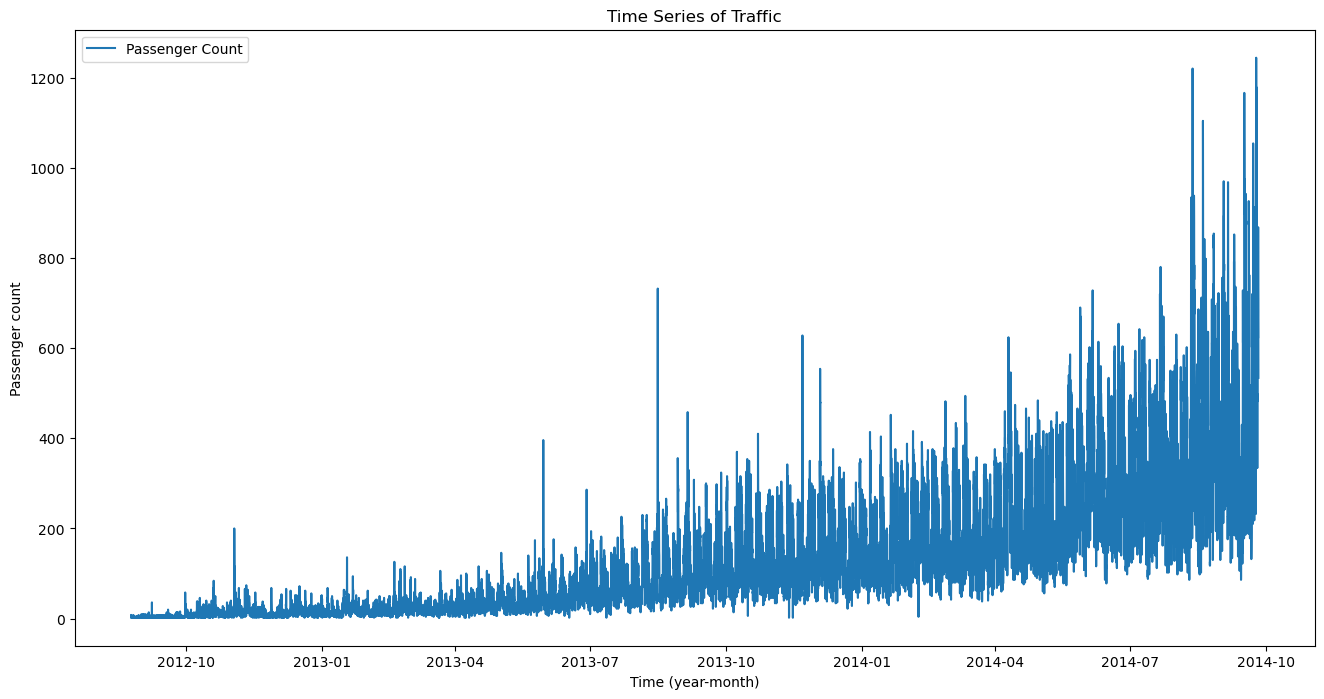

In [14]:
plt.figure(figsize=(16, 8))
plt.plot(train['Count'], label='Passenger Count')
plt.title('Time Series of Traffic')
plt.xlabel('Time (year-month)')
plt.ylabel('Passenger count')
plt.legend(loc='best');

* The time series plot shows that there is an increasing trend in the series, i.e., the number of passenger count is increasing with respect to time. 
* We can also see that at certain points there is a suddent increase in the number of counts. The possible reason behindd this could be that on particular day, due to some event the traffic was high.

Let's recall the hypothesis that we made earlier:
* Traffic will increase as the years pass by
* Traffic will be high from May to October
* Traffic on weekdays will be more
* Traffic during the peak hours will be high

After having a look at the datasets, we will now try to validate our hypothesis and make other inferences from the datasets.

### 5. Exploratory Analysis

Let us try to verify our hypothesis using the actual data.

Our first hypothesis is traffic will increase as the years pass by. So let's look at yearly passenger count.

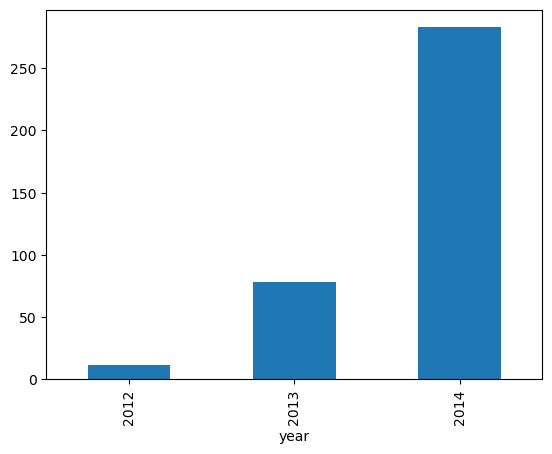

In [15]:
train.groupby('year')['Count'].mean().plot.bar();

We see an exponential growth in the traffic with respect to year which validates our hypothesis.

Our second hypothesis is about increase in traffic from May to October. So, let's see the relation between count and month.

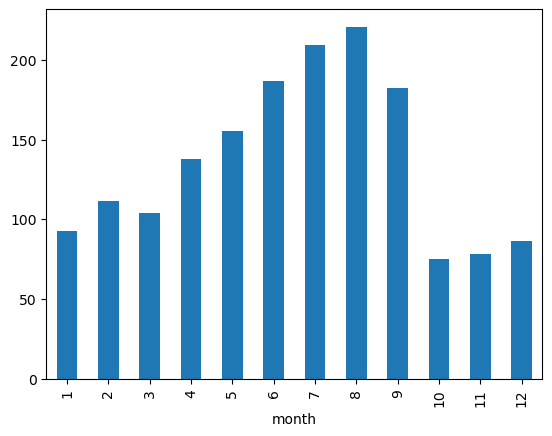

In [16]:
train.groupby('month')['Count'].mean().plot.bar();

Here we see a decrease in the mean of passenger count in last three months. This does not look right. Let's look at the monthly mean of each year separately.

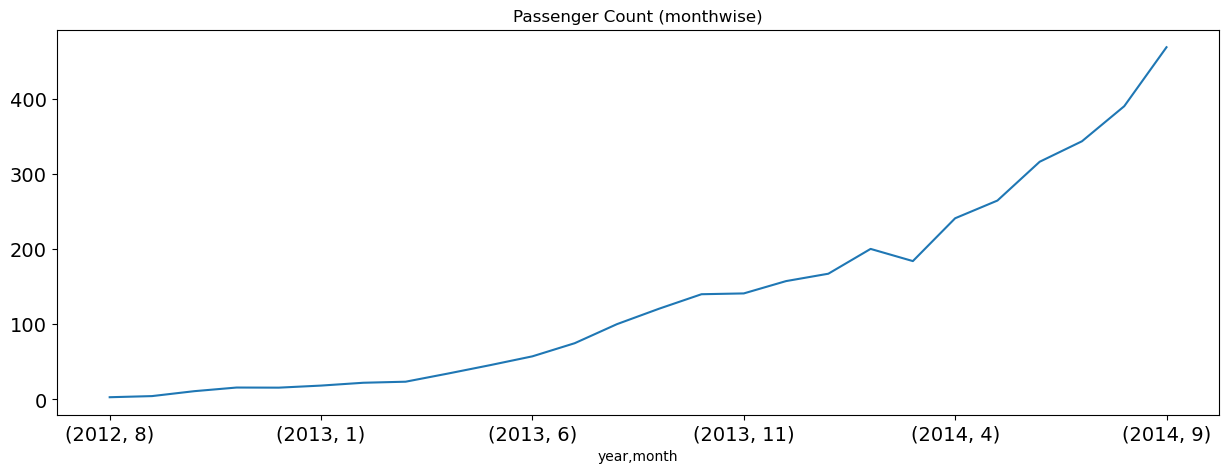

In [17]:
temp = train.groupby(['year', 'month'])['Count'].mean()
temp.plot(figsize=(15, 5), title='Passenger Count (monthwise)', fontsize=14);

* It can be seen that the months 10, 11 and 12 are not present for the year 2014 and the mean values for these months in year 2012 is very less.
* In the above line plot we can see an increasing trend in monthly passenger count and the growth is approximately exponential. 

Next, let's look at the daily mean of passenger count.

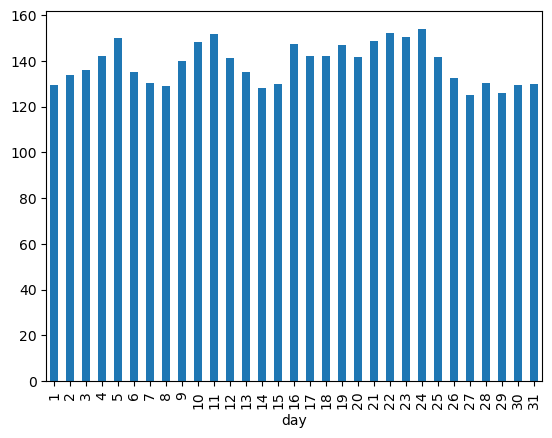

In [18]:
train.groupby('day')['Count'].mean().plot.bar();

It does not show many insights from daywise count of passengers.

We also make a hypothesis that the traffic will be more during peak hours. So let's see the mmean of hourly passenger count.

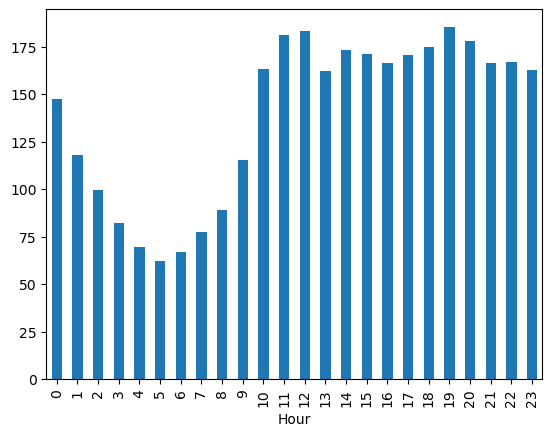

In [19]:
train.groupby('Hour')['Count'].mean().plot.bar();

* It can be inferred that the peak traffic is at `7pm` and then we can see a decreasing trend till `5pm`.
* After that the passenger count starts increasing again and peaks again between `11am` and `12pm`.

Next, let's try to validate our hypothesis in which we assume that the traffic will be more on weekdays.

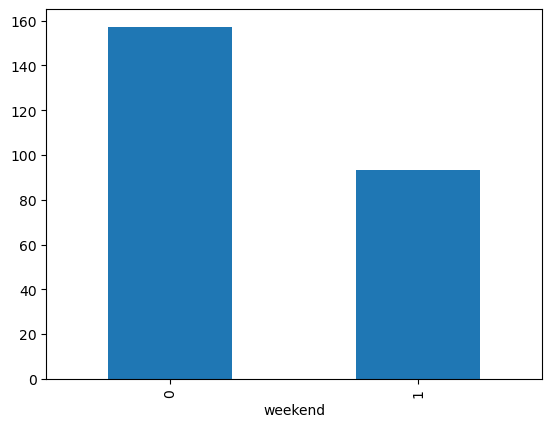

In [20]:
train.groupby('weekend')['Count'].mean().plot.bar();

It can be inferred from the above figure that the traffic is more on weekdays as compared to weekends which validates our hypothesis.

Now we will try to look at the daywise passenger count. **Note** - 0 is the starting of the week, i.e., 0 is Monday and 6 is Sunday.

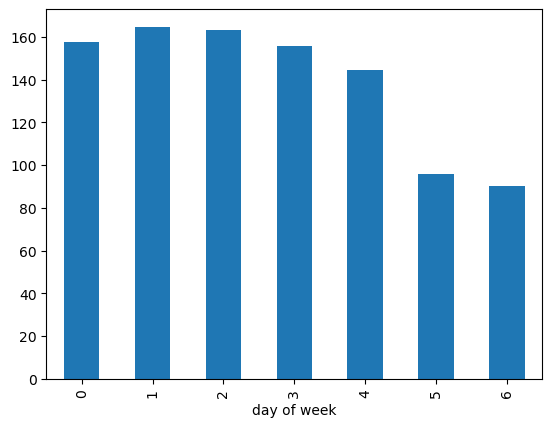

In [21]:
train.groupby('day of week')['Count'].mean().plot.bar();

From the above figure, we can infer that the passenger count is less for Saturday and Sunday as compared to the other days of the week. 

Next, we will look at basic mmodeling techniques. Before that we will drop the `ID` column as it has nothing to do with the passenger count.

In [22]:
train.drop('ID', 1)

Datetime  Count  year  month  day  Hour  \
Datetime                                                                 
2012-08-25 00:00:00 2012-08-25 00:00:00      8  2012      8   25     0   
2012-08-25 01:00:00 2012-08-25 01:00:00      2  2012      8   25     1   
2012-08-25 02:00:00 2012-08-25 02:00:00      6  2012      8   25     2   
2012-08-25 03:00:00 2012-08-25 03:00:00      2  2012      8   25     3   
2012-08-25 04:00:00 2012-08-25 04:00:00      2  2012      8   25     4   
...                                 ...    ...   ...    ...  ...   ...   
2014-09-25 19:00:00 2014-09-25 19:00:00    868  2014      9   25    19   
2014-09-25 20:00:00 2014-09-25 20:00:00    732  2014      9   25    20   
2014-09-25 21:00:00 2014-09-25 21:00:00    702  2014      9   25    21   
2014-09-25 22:00:00 2014-09-25 22:00:00    580  2014      9   25    22   
2014-09-25 23:00:00 2014-09-25 23:00:00    534  2014      9   25    23   

                     day of week  weekend  
Datetime                                   
2012-08-25 00:00:00            5        1  
2012-08-25 01:00:00            5        1  
2012-08-25 02:00:00            5        1  
2012-08-25 03:00:00            5        1  
2012-08-25 04:00:00            5        1  
...                          ...      ...  
2014-09-25 19:00:00            3        0  
2014-09-25 20:00:00            3        0  
2014-09-25 21:00:00            3        0  
2014-09-25 22:00:00            3        0  
2014-09-25 23:00:00            3        0  

[18288 rows x 8 columns]

As it can be seen that there is a lot of noises in the hourly time series, we will aggregate the hourly tiem series to daily, weekly and monthly time series to reduce the noise the make it more stale and hence would be easier for a model to learn.

In [23]:
train.Timestamp = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
train.index = train.Timestamp
train.head()

ID            Datetime  Count  year  month  day  Hour  \
Datetime                                                                     
2012-08-25 00:00:00   0 2012-08-25 00:00:00      8  2012      8   25     0   
2012-08-25 01:00:00   1 2012-08-25 01:00:00      2  2012      8   25     1   
2012-08-25 02:00:00   2 2012-08-25 02:00:00      6  2012      8   25     2   
2012-08-25 03:00:00   3 2012-08-25 03:00:00      2  2012      8   25     3   
2012-08-25 04:00:00   4 2012-08-25 04:00:00      2  2012      8   25     4   

                     day of week  weekend  
Datetime                                   
2012-08-25 00:00:00            5        1  
2012-08-25 01:00:00            5        1  
2012-08-25 02:00:00            5        1  
2012-08-25 03:00:00            5        1  
2012-08-25 04:00:00            5        1

In [24]:
# Resample to hourly mean
hourly = train.resample('H').mean()

# Resample to daily mean
daily = train.resample('D').mean()

# Resample to weekly mean
weekly = train.resample('W').mean()

# Resample to monthly mean
monthly = train.resample('M').mean()

Let's look at the hourly, daily, weekly and monthly time series.

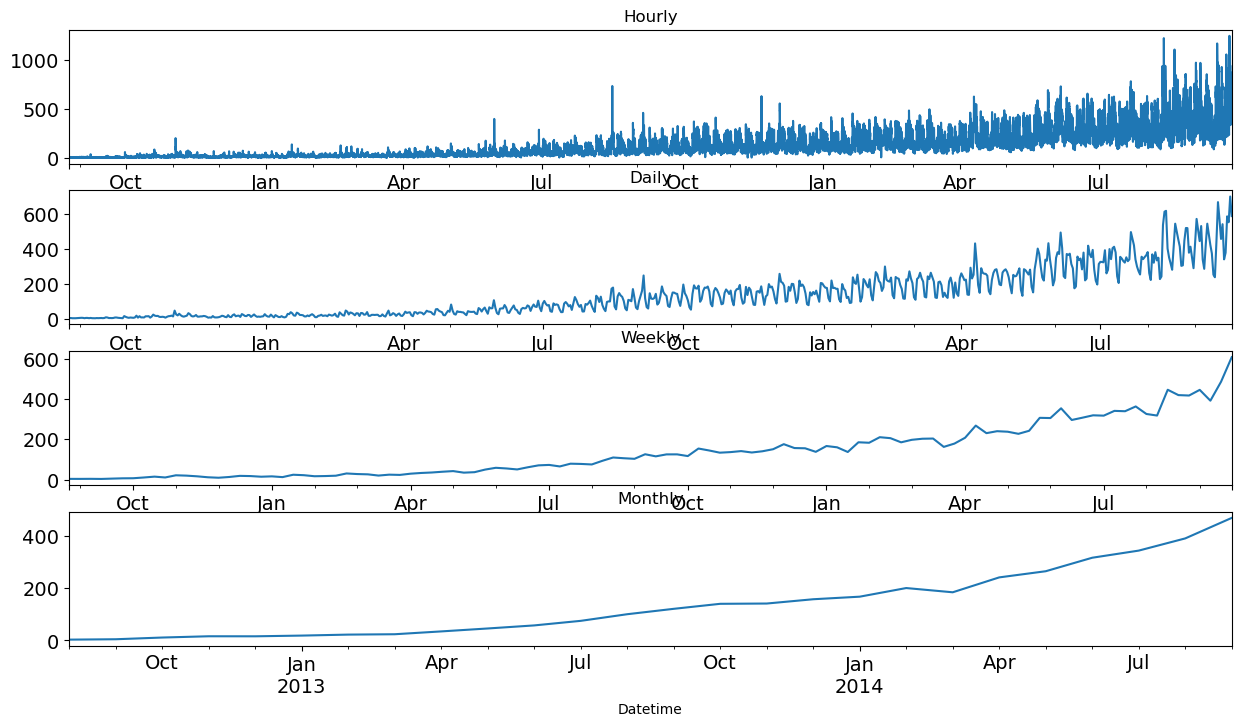

In [25]:
fig, axs = plt.subplots(4, 1)
hourly.Count.plot(figsize=(15, 8), title='Hourly', fontsize=14, ax=axs[0])
daily.Count.plot(figsize=(15, 8), title='Daily', fontsize=14, ax=axs[1])
weekly.Count.plot(figsize=(15, 8), title='Weekly', fontsize=14, ax=axs[2])
monthly.Count.plot(figsize=(15, 8), title='Monthly', fontsize=14, ax=axs[3])

We can see that the time series is becoming more and more stable when we are aggregating it on daily, weekly and monthly basis.

But it would be difficult to convert the monthly and weekly predictions to hourly predictions, as first we have to convert the monthly predictions to weekly, weekly to daily and daily to hourly predictions, which will become very expanded process. So, we will work on the daily time series.

In [26]:
test.Timestamp = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
test.index = test.Timestamp
test.head()

ID            Datetime  year  month  day  Hour
Datetime                                                              
2014-09-26 00:00:00  18288 2014-09-26 00:00:00  2014      9   26     0
2014-09-26 01:00:00  18289 2014-09-26 01:00:00  2014      9   26     1
2014-09-26 02:00:00  18290 2014-09-26 02:00:00  2014      9   26     2
2014-09-26 03:00:00  18291 2014-09-26 03:00:00  2014      9   26     3
2014-09-26 04:00:00  18292 2014-09-26 04:00:00  2014      9   26     4

In [27]:
# Convert to daily mean
test = test.resample('D').mean()
test.head()

ID    year  month   day  Hour
Datetime                                      
2014-09-26  18299.5  2014.0    9.0  26.0  11.5
2014-09-27  18323.5  2014.0    9.0  27.0  11.5
2014-09-28  18347.5  2014.0    9.0  28.0  11.5
2014-09-29  18371.5  2014.0    9.0  29.0  11.5
2014-09-30  18395.5  2014.0    9.0  30.0  11.5

In [28]:
# Convert to daily mean
train = train.resample('D').mean()
train.head()

ID     Count    year  month   day  Hour  day of week  weekend
Datetime                                                                    
2012-08-25   11.5  3.166667  2012.0    8.0  25.0  11.5          5.0      1.0
2012-08-26   35.5  3.666667  2012.0    8.0  26.0  11.5          6.0      1.0
2012-08-27   59.5  2.583333  2012.0    8.0  27.0  11.5          0.0      0.0
2012-08-28   83.5  2.416667  2012.0    8.0  28.0  11.5          1.0      0.0
2012-08-29  107.5  2.500000  2012.0    8.0  29.0  11.5          2.0      0.0

## Modelling Techniques and Evaluation
As we have validated all our hypothesis, let's go ahead and build models for time series forecasting.

We generally divide the training dataset into two parts. One part is used to train the model and the other part is used as the `validation dataset` to check the accuracy of our predictions.

### 1. Splitting the data into training and validation parts
To divide the data into training and validation sets, we will take last 3 months as the validation data and rest for training data. We will take 3 months as the trend will be the most in them. If we take more than 3 months for the validation set, our training set will have less data points as the total duration is of 25 months. 

If we would have done it randomly it may work well for the training dataset but will not work effectively on validation dataset. Let's understand it in this way: if we choose the split randomly it will take some values from the starting and some from the last years as well. It is similar to predicting the old values based on the future values which is not the case in real scenario.So, this kind of split is used while working with time related problems.

The starting date of the dataset is `25-08-2012` as we have seen the exploration part and the end date is `25-09-2014`.

In [29]:
Train = train.loc['2012-08-25': '2014-06-24'] # both ends are inclusive
Train

ID       Count    year  month   day  Hour  day of week  \
Datetime                                                                  
2012-08-25     11.5    3.166667  2012.0    8.0  25.0  11.5          5.0   
2012-08-26     35.5    3.666667  2012.0    8.0  26.0  11.5          6.0   
2012-08-27     59.5    2.583333  2012.0    8.0  27.0  11.5          0.0   
2012-08-28     83.5    2.416667  2012.0    8.0  28.0  11.5          1.0   
2012-08-29    107.5    2.500000  2012.0    8.0  29.0  11.5          2.0   
...             ...         ...     ...    ...   ...   ...          ...   
2014-06-20  15947.5  379.916667  2014.0    6.0  20.0  11.5          4.0   
2014-06-21  15971.5  220.083333  2014.0    6.0  21.0  11.5          5.0   
2014-06-22  15995.5  230.833333  2014.0    6.0  22.0  11.5          6.0   
2014-06-23  16019.5  419.416667  2014.0    6.0  23.0  11.5          0.0   
2014-06-24  16043.5  372.166667  2014.0    6.0  24.0  11.5          1.0   

            weekend  
Datetime             
2012-08-25      1.0  
2012-08-26      1.0  
2012-08-27      0.0  
2012-08-28      0.0  
2012-08-29      0.0  
...             ...  
2014-06-20      0.0  
2014-06-21      1.0  
2014-06-22      1.0  
2014-06-23      0.0  
2014-06-24      0.0  

[669 rows x 8 columns]

In [30]:
Valid = train.loc['2014-06-25': '2014-09-25']
Valid

ID       Count    year  month   day  Hour  day of week  \
Datetime                                                                  
2014-06-25  16067.5  353.666667  2014.0    6.0  25.0  11.5          2.0   
2014-06-26  16091.5  395.250000  2014.0    6.0  26.0  11.5          3.0   
2014-06-27  16115.5  282.333333  2014.0    6.0  27.0  11.5          4.0   
2014-06-28  16139.5  218.250000  2014.0    6.0  28.0  11.5          5.0   
2014-06-29  16163.5  196.250000  2014.0    6.0  29.0  11.5          6.0   
...             ...         ...     ...    ...   ...   ...          ...   
2014-09-21  18179.5  379.250000  2014.0    9.0  21.0  11.5          6.0   
2014-09-22  18203.5  588.166667  2014.0    9.0  22.0  11.5          0.0   
2014-09-23  18227.5  554.333333  2014.0    9.0  23.0  11.5          1.0   
2014-09-24  18251.5  702.333333  2014.0    9.0  24.0  11.5          2.0   
2014-09-25  18275.5  589.666667  2014.0    9.0  25.0  11.5          3.0   

            weekend  
Datetime             
2014-06-25      0.0  
2014-06-26      0.0  
2014-06-27      0.0  
2014-06-28      1.0  
2014-06-29      1.0  
...             ...  
2014-09-21      1.0  
2014-09-22      0.0  
2014-09-23      0.0  
2014-09-24      0.0  
2014-09-25      0.0  

[93 rows x 8 columns]

Now let's look at how the training and validation parts have been divided by visualization.

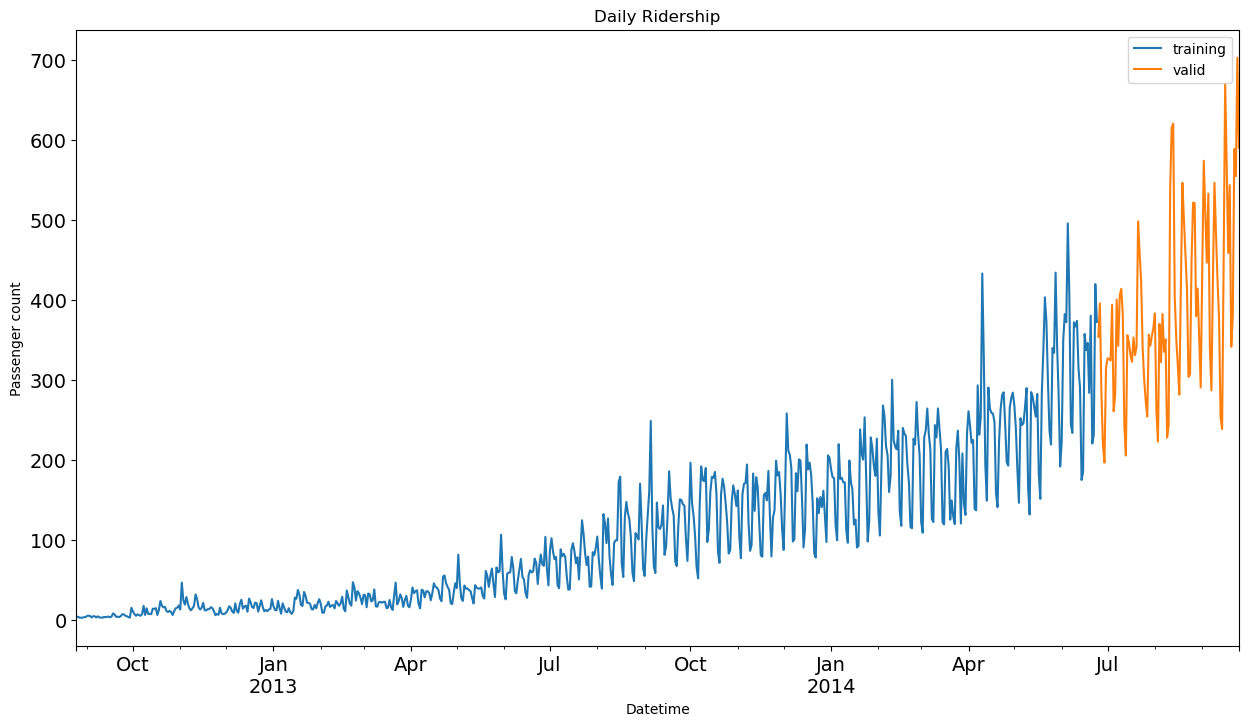

In [31]:
Train.Count.plot(figsize=(15, 8), title='Daily Ridership', fontsize=14, label='training');
Valid.Count.plot(figsize=(15, 8), title='Daily Ridership', fontsize=14, label='valid');
plt.xlabel('Datetime')
plt.ylabel('Passenger count')
plt.legend(loc='best');

Here the blue part represents the training data and the orange part represents the validation datdda.

We will predict the traffic for the validation part and then visualize how accurate our predictions are. Finally we will make predictions for the test dataset.
We will look at various models now to forecast the time series.

#### <span style='color:blue'> (1) Naive Approach </span>
In this forecasting technique, we assume that the **next expected point is equal to that last observed point**. So we can expect a straight horizontal line as the prediction.

Let's make predictions using native approach for the validation set.

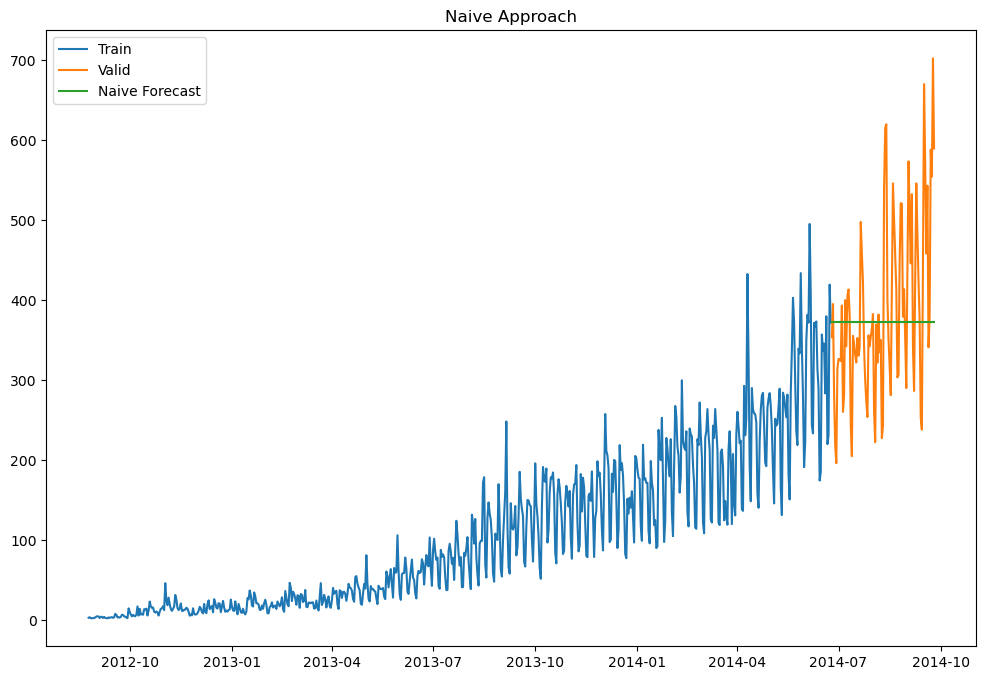

In [34]:
dd = np.asarray(Train.Count)
y_hat = Valid.copy()
y_hat['naive'] = dd[len(dd)-1] # all the predictions aree equal to the last observed point

plt.figure(figsize=(12, 8))
plt.plot(Train.index, Train['Count'], label='Train')
plt.plot(Valid.index, Valid['Count'], label='Valid')
plt.plot(y_hat.index, y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title('Naive Approach');

* We can calculate how accurate our predictions are using **Root Mean Squared Error (RMSE)**.
* RMSE is the standard deviation of the residuals.
* Residuals are a measure of how far from the regression line data points are.
* The formula for RMSE is: $RMSE=\sqrt{\frac{1}{n}\Sigma_{i=1}^n(\hat{y}_i - y_i)^2}$, where $\hat{y}$ is the predicted value.

Now let's compute RMSE to check the accuracy of our model on the validation dataset.

In [35]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(Valid['Count'], y_hat['naive']))
print(f'The performance of naive approach is: RMSE={rmse}')

The performance of naive approach is: RMSE=111.79050467496724


#### <span style='color:blue'> (2) Moving Average </span>
In this forecasting technique, we will **take the average of the passenger counts for last few time periods only**. Here the predictions are made on the basis of the average of last few points instead of taking all the previously known values.

Let's try the rolling mean for last 10, 20, 50 days and visualize the results.

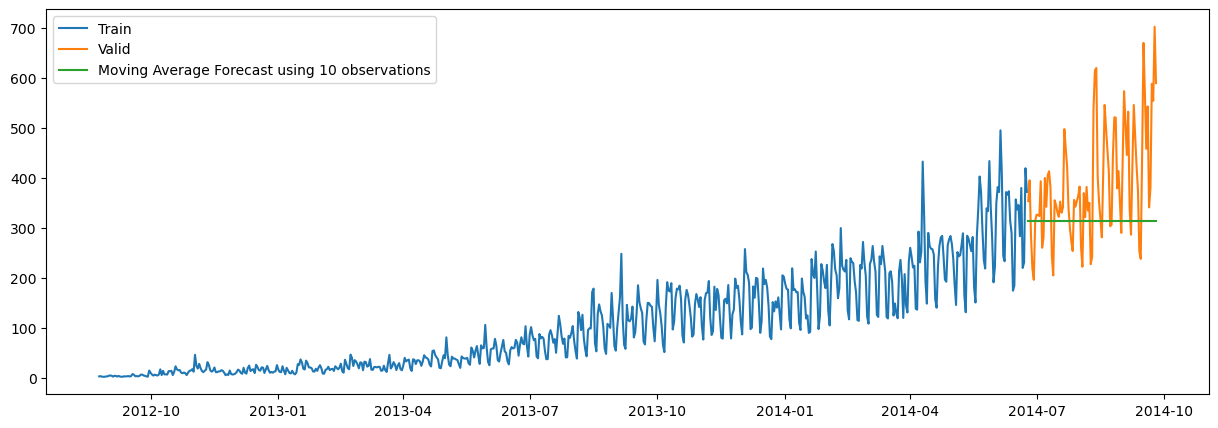

In [41]:
y_hat_avg = Valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(10).mean().iloc[-1] # average of last 10 observations

plt.figure(figsize=(15, 5))
plt.plot(Train['Count'], label='Train')
plt.plot(Valid['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 10 observations')
plt.legend(loc='best');

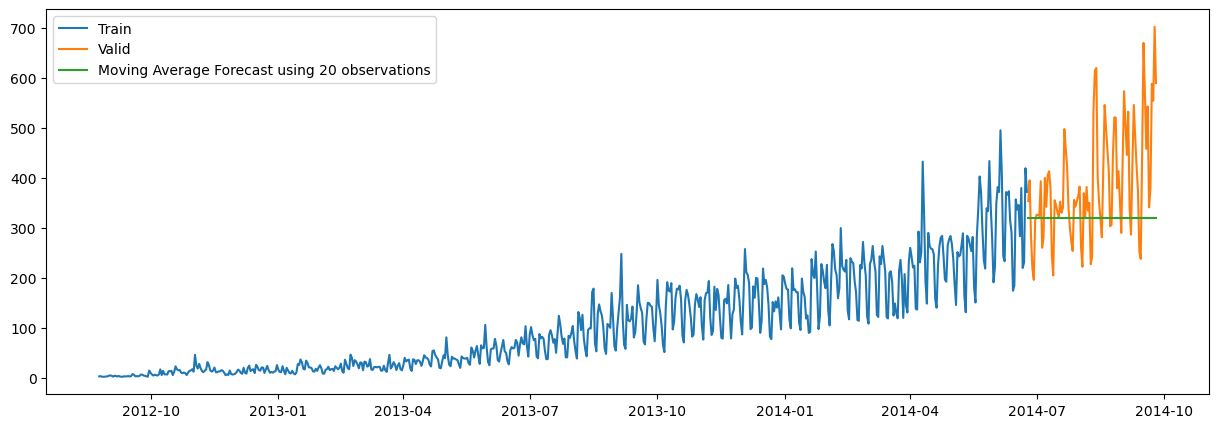

In [42]:
y_hat_avg = Valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(20).mean().iloc[-1] # average of last 20 observations

plt.figure(figsize=(15, 5))
plt.plot(Train['Count'], label='Train')
plt.plot(Valid['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 20 observations')
plt.legend(loc='best');

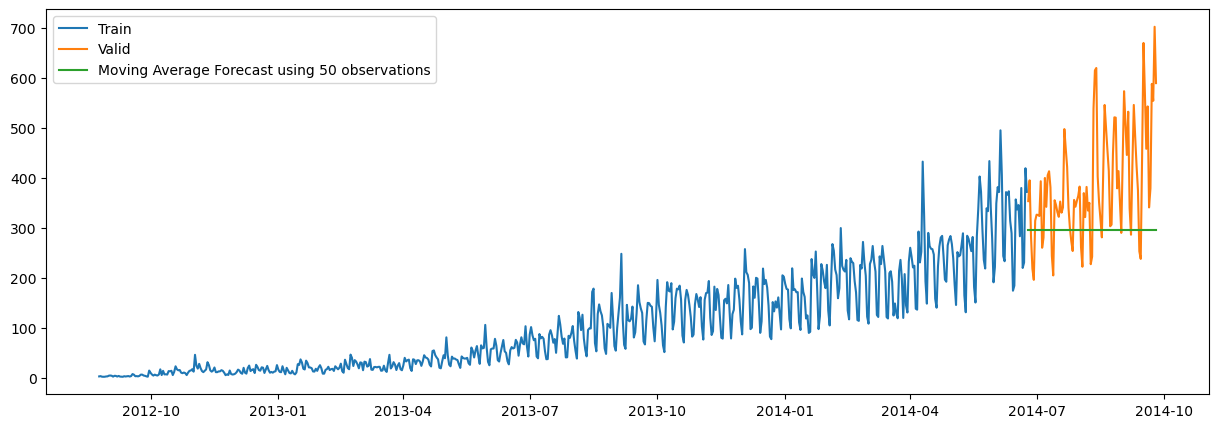

In [43]:
y_hat_avg = Valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(50).mean().iloc[-1] # average of last 50 observations

plt.figure(figsize=(15, 5))
plt.plot(Train['Count'], label='Train')
plt.plot(Valid['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 50 observations')
plt.legend(loc='best');

We take the average of last 10, 20 and 50 observations and predict based on that. This value can be changed in the above code in `.rolling().mean()` part. We can see that the predictions are getting weaker as we increase the number of observations.

In [45]:
rmse_avg = sqrt(mean_squared_error(Valid['Count'], y_hat_avg['moving_avg_forecast']))
print(f'The performance of moving average is: RMSE={rmse_avg}')

The performance of moving average is: RMSE=144.19175679986793


#### <span style='color:blue'> (3) Simple Exponential Smoothing </span>
In this forecasting technique, we **assign larger weigths to more recent observations than to observations from distant past**. The **weights decrease exponentially** as observations come from further in the past, the smallest weights are associated with the oldest observations.

**NOTE** - If we give the entire weight to the last observed value only, this method will be similar to the naive approach. So, we can say that naive approach is also a simple exponential smoothing technique where the entire weight is given to the last observed value.

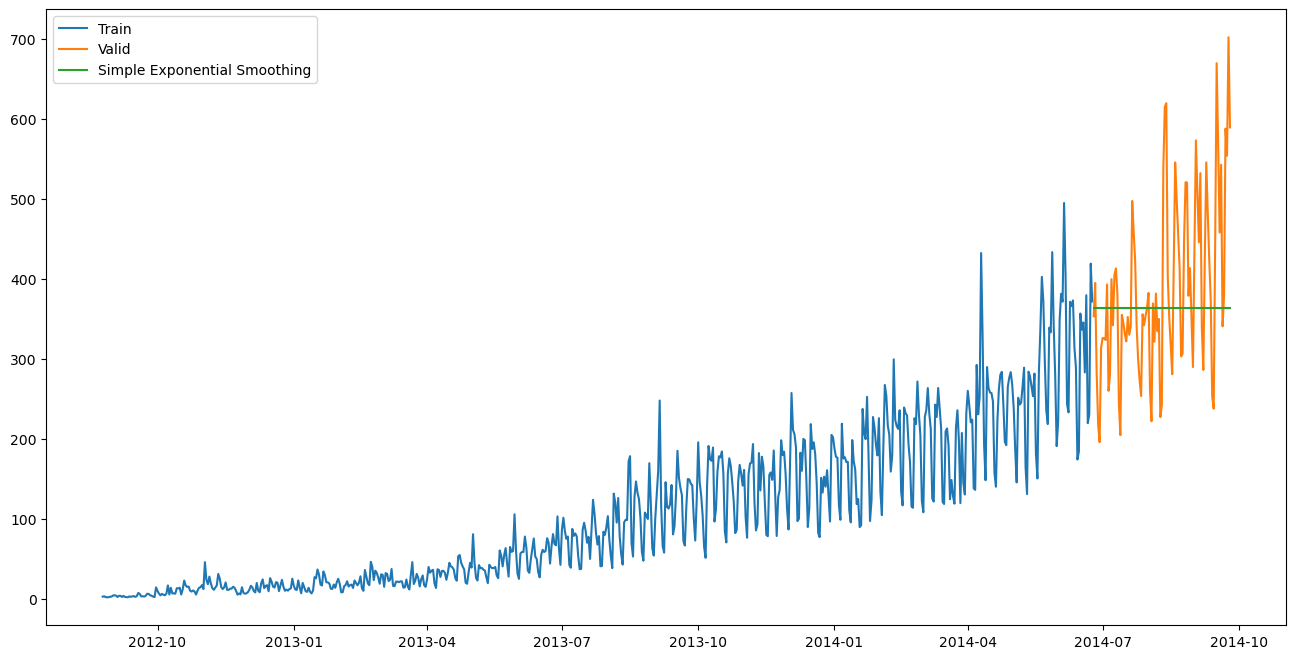

In [48]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_SES = Valid.copy()
SES = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.6, optimized=False)
y_hat_SES['SES'] = SES.forecast(len(Valid))

plt.figure(figsize=(16, 8))
plt.plot(Train['Count'], label='Train')
plt.plot(Valid['Count'], label='Valid')
plt.plot(y_hat_SES['SES'], label='Simple Exponential Smoothing')
plt.legend(loc='best');

In [50]:
rmse_ses = sqrt(mean_squared_error(Valid['Count'], y_hat_SES['SES']))
print(f'The performance of simple exponential smoothing is: RMSE={rmse_ses}')

The performance of simple exponential smoothing is: RMSE=113.43708111884514


#### <span style='color:blue'> (4) Holt's Linear Trend Model </span>
* It is an extension of simple exponential smoothing to allow **forecasting of data with trend**.
* This method **takes into account the trend of the dataset**. The forecast function in this method is a function of level and trend.

First of all let's visualize the `trend`, `seasonality` and `error` in the time series.

We can decompose the time series in four parts.
* `Observed`, which is the original time series
* `Trend`, which shows the trend in the time series, i.e., increasing or decreasing behaviour of the time series
* `Seasonal`, which tells us about the seasonality in the time series
* `Residual`, which is obtained by removing any trend or seasonality in the time series

Next, let's visualize all these parts.

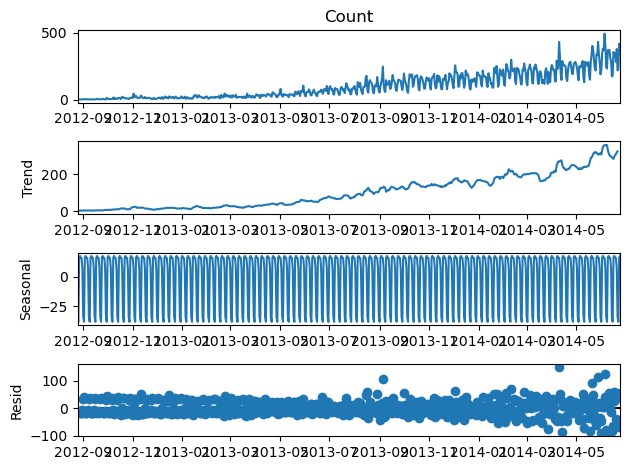

In [56]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(Train['Count']).plot();
result = sm.tsa.stattools.adfuller(Train['Count'])

An increasing trend can be seen in the dataset, so now we will make aa model based on the trend.

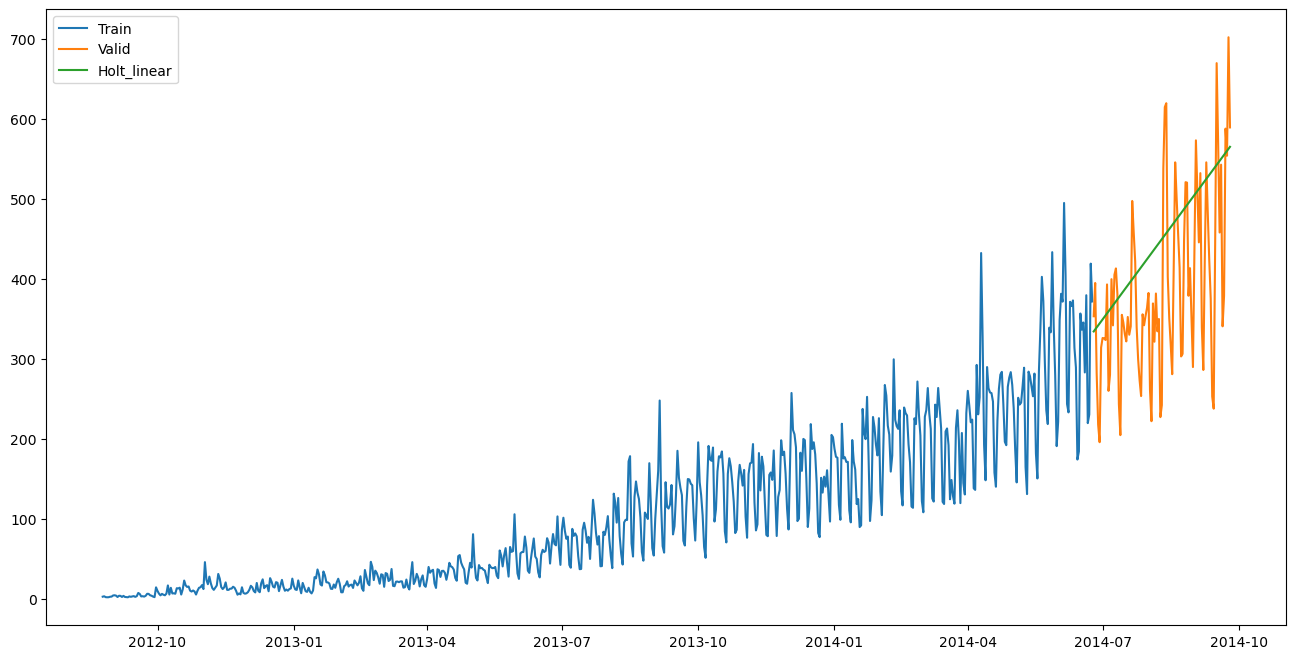

In [59]:
y_hat_holt = Valid.copy()
holt = Holt(np.asarray(Train['Count'])).fit(smoothing_level=0.3, smoothing_slope=0.1)
y_hat_holt['Holt_linear'] = holt.forecast(len(Valid))

plt.figure(figsize=(16, 8))
plt.plot(Train['Count'], label='Train')
plt.plot(Valid['Count'], label='Valid')
plt.plot(y_hat_holt['Holt_linear'], label='Holt_linear')
plt.legend(loc='best');

We can see an inclined line here as the model has taken into consideration the `trend` of the time series.
Let's compute the RMSE of the model.

In [62]:
rmse_holt = sqrt(mean_squared_error(Valid['Count'], y_hat_holt['Holt_linear']))
print(f'The performance of the Holt\'s Linear Trend Model is: RMSE={rmse_holt}')

The performance of the Holt's Linear Trend Model is: RMSE=112.94278345314041


Now we will be predicting the passenger count for the test dataset using Holt's Linear Trend model.
* We will make holt's linear trend model on the daily time series and make predictions on the test dataset.
* We will make predictions based on the daily time series and then will distribute that daily prediction to hourly predictions.

Now let's load the submission file.

In [65]:
submission = pd.read_csv('./data/sample_submission_LSeus50.csv')
submission

ID  Count
0     18288      0
1     18289      0
2     18290      0
3     18291      0
4     18292      0
...     ...    ...
5107  23395      0
5108  23396      0
5109  23397      0
5110  23398      0
5111  23399      0

[5112 rows x 2 columns]

In [66]:
# Make predictions on the test dataset
predict_holt = holt.forecast(len(test))

# Savv these predictions in test file in a new column
test['Prediction_holt'] = predict_holt

Remember this is the **daily predictions**. We have to convert these predictions to hourly basis. To do so, we will first calculate the ratio of passenger count for each hour of every day. Then we will find the average ratio of passenger count for each hour and we will get 24 ratios. Then to calculate the hourly predictions we will multiply the daily predictions with the average hourly ratio.

In [84]:
# Calculate the hourly ratio of count
train_original['ratio'] = train_original['Count'] / train_original['Count'].sum()

# Group the hourly ratio
temp = train_original.groupby(['Hour'])['ratio'].sum()

# Groupby to csv format
hourly_ratio = pd.DataFrame(temp).reset_index()
hourly_ratio.to_csv('./data/hourly_ratio.csv')
hourly_ratio.head()

Hour     ratio
0     0  0.044287
1     1  0.035343
2     2  0.029911
3     3  0.024714
4     4  0.020802

In [85]:
test.head()

ID    year  month   day  Hour  Prediction_holt
Datetime                                                       
2014-09-26  18299.5  2014.0    9.0  26.0  11.5       334.650767
2014-09-27  18323.5  2014.0    9.0  27.0  11.5       337.159011
2014-09-28  18347.5  2014.0    9.0  28.0  11.5       339.667256
2014-09-29  18371.5  2014.0    9.0  29.0  11.5       342.175500
2014-09-30  18395.5  2014.0    9.0  30.0  11.5       344.683745

In [86]:
test_original.head()

ID            Datetime  year  month  day  Hour
0  18288 2014-09-26 00:00:00  2014      9   26     0
1  18289 2014-09-26 01:00:00  2014      9   26     1
2  18290 2014-09-26 02:00:00  2014      9   26     2
3  18291 2014-09-26 03:00:00  2014      9   26     3
4  18292 2014-09-26 04:00:00  2014      9   26     4

In [87]:
# Merge test and test_original on day, month and year
merge = pd.merge(test, test_original, on=('day', 'month', 'year'), how='left')
merge.head()

ID_x    year  month   day  Hour_x  Prediction_holt   ID_y  \
0  18299.5  2014.0    9.0  26.0    11.5       334.650767  18288   
1  18299.5  2014.0    9.0  26.0    11.5       334.650767  18289   
2  18299.5  2014.0    9.0  26.0    11.5       334.650767  18290   
3  18299.5  2014.0    9.0  26.0    11.5       334.650767  18291   
4  18299.5  2014.0    9.0  26.0    11.5       334.650767  18292   

             Datetime  Hour_y  
0 2014-09-26 00:00:00       0  
1 2014-09-26 01:00:00       1  
2 2014-09-26 02:00:00       2  
3 2014-09-26 03:00:00       3  
4 2014-09-26 04:00:00       4

In [88]:
merge['Hour'] = merge['Hour_y']
merge = merge.drop(['year', 'month', 'Hour_x', 'Datetime', 'Hour_y'], axis=1)
merge.head()

ID_x   day  Prediction_holt   ID_y  Hour
0  18299.5  26.0       334.650767  18288     0
1  18299.5  26.0       334.650767  18289     1
2  18299.5  26.0       334.650767  18290     2
3  18299.5  26.0       334.650767  18291     3
4  18299.5  26.0       334.650767  18292     4

In [91]:
# Predict by merging merge and temp (hourly rate)
prediction_holt = pd.merge(merge, temp, on='Hour', how='left')
prediction_holt.head()

ID_x   day  Prediction_holt   ID_y  Hour     ratio
0  18299.5  26.0       334.650767  18288     0  0.044287
1  18299.5  26.0       334.650767  18289     1  0.035343
2  18299.5  26.0       334.650767  18290     2  0.029911
3  18299.5  26.0       334.650767  18291     3  0.024714
4  18299.5  26.0       334.650767  18292     4  0.020802

In [92]:
# Convert the Count to the original scale
prediction_holt['Count'] = prediction_holt['Prediction_holt'] * prediction_holt['ratio'] * 24
prediction_holt['ID'] = prediction_holt['ID_y']
prediction_holt.head()

ID_x   day  Prediction_holt   ID_y  Hour     ratio       Count     ID
0  18299.5  26.0       334.650767  18288     0  0.044287  355.692974  18288
1  18299.5  26.0       334.650767  18289     1  0.035343  283.861602  18289
2  18299.5  26.0       334.650767  18290     2  0.029911  240.234347  18290
3  18299.5  26.0       334.650767  18291     3  0.024714  198.497058  18291
4  18299.5  26.0       334.650767  18292     4  0.020802  167.075574  18292

In [94]:
# Let's drop all other columns different from the submission file and keep ID and Count only
submission = prediction_holt.drop(['ID_x', 'day', 'Prediction_holt', 'ID_y', 'Hour', 'ratio'], axis=1)
submission

Count     ID
0      355.692974  18288
1      283.861602  18289
2      240.234347  18290
3      198.497058  18291
4      167.075574  18292
...           ...    ...
5107  1156.675482  23395
5108  1111.525192  23396
5109  1037.491153  23397
5110  1041.255041  23398
5111  1016.642487  23399

[5112 rows x 2 columns]

In [95]:
# Convert the final submission to csv format
pd.DataFrame(submission, columns=['ID', 'Count']).to_csv('Holt_linear.csv')

#### <span style='color:blue'> (5) Holt Winter's Model </span>
* Dataset which show a similar set of pattern after fixed intervals of a time period suffer from seasonality.
* Thee idea behind Holt's Winter is to apply exponential smoothing to the `seasonal components` in addition to `level` and `trend`.

Let's first fit the model on training dataset and validate it using the validation dataset.

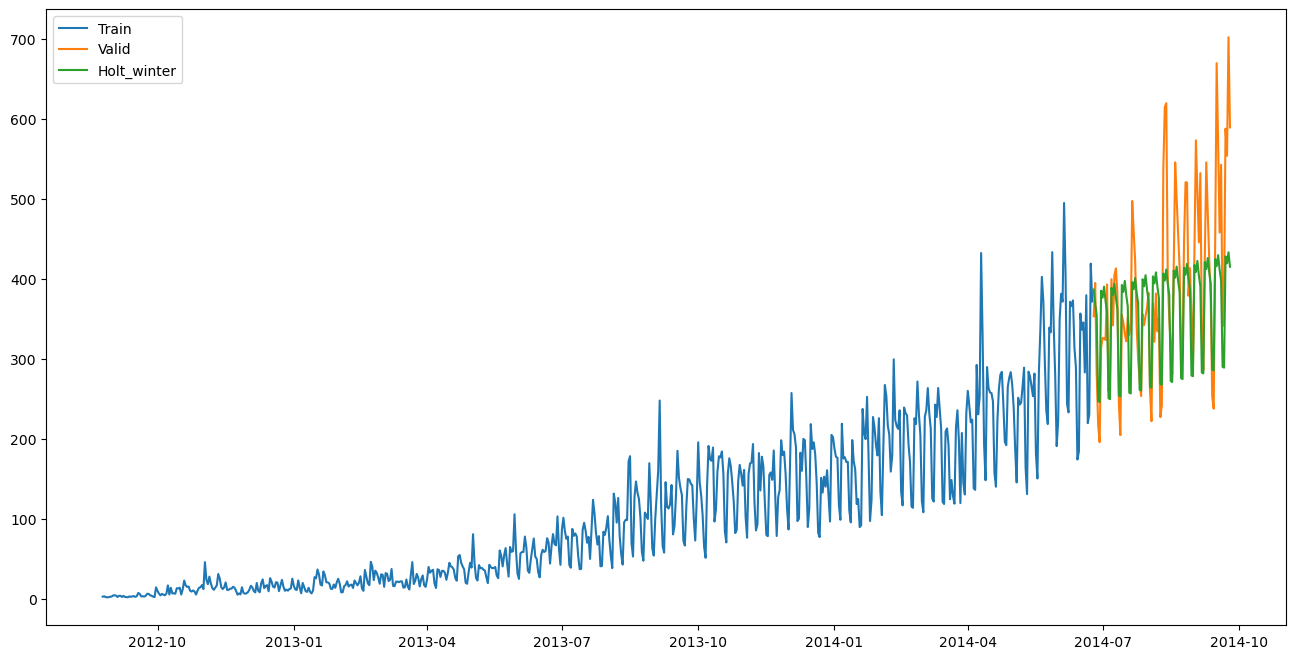

In [96]:
y_hat_winter = Valid.copy()
holt_winter = ExponentialSmoothing(np.asarray(Train['Count']), seasonal_periods=7, trend='add', seasonal='add').fit()
y_hat_winter['Holt_winter'] = holt_winter.forecast(len(Valid))

plt.figure(figsize=(16, 8))
plt.plot(Train['Count'], label='Train')
plt.plot(Valid['Count'], label='Valid')
plt.plot(y_hat_winter['Holt_winter'], label='Holt_winter')
plt.legend(loc='best');

In [97]:
rmse_holt_winter = sqrt(mean_squared_error(Valid['Count'], y_hat_winter['Holt_winter']))
print(f'The performance of the Holt Winter\'s Model is: RMSE={rmse_holt_winter}')

The performance of the Holt Winter's Model is: RMSE=82.06772497115004


We can see that the RMSE value has reduced a lot from this method. Let's forecast the `Count` for the entire length of the test dataset.

In [98]:
predict_holt_winter = holt_winter.forecast(len(test))

Now we can convert these daily passenger count into hourly passenger count using the same approach earlier.

In [100]:
test['prediction_holt_winter'] = predict_holt_winter

# Merge test and test_original on day, month and year
merge = pd.merge(test, test_original, on=('day', 'month', 'year'), how='left')
merge['Hour'] = merge['Hour_y']
merge.drop(['year', 'month', 'Datetime', 'Hour_x', 'Hour_y'], axis=1)

# Predict by merging merge and temp (hourly rate)
prediction_holt_winter = pd.merge(merge, temp, on='Hour', how='left')

# Convert the Count to the original ratio
prediction_holt_winter['Count'] = prediction_holt_winter['prediction_holt_winter'] * prediction_holt_winter['ratio']*24

# Drop all columns other than ID and Count
prediction_holt_winter['ID'] = prediction_holt_winter['ID_y']
submission = prediction_holt_winter.drop(['ID_x', 'day', 'prediction_holt_winter', 'ID_y', 'Hour', 'ratio'], axis=1)

In [101]:
# Convert the final submission to csv format
pd.DataFrame(submission, columns=['ID', 'Count']).to_csv('Holt_winter.csv')

#### <span style='color:blue'> (6) ARIMA Model </span>
* ARIMA stands for Auto Regression Integrated Moving Average. It is specified by three ordered parameters (p, d, q).
    * `p` is the order of the autoregressive model (number of time lags)
    * `d` is the degree of differencing (number of times the data have had past values substracted)
    * `q` is the order of moving average model
    
The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation.

**What are Stationary Time Series?**: There are three basic criterion for a time series to be classified as stationary series:
1. The `mean` of the time series should not bee a function of time. It should be constant.
2. The `variance` of the time series should not be a function of time.
3. The `covariance` of the $i$-th term and the $(i+m)$-th term should not be a function of time.

**Why do we have to make the time series stationary?**: <br>
* We make the series stationary to make variables independent. Variables can be dependent in various ways, but can only be independent in one way. So, we will get more information when they are independent. Hence the time series must be stationary.
* *If the time series is not stationary, firstly we have to make it stationary before we apply ARIMA model*. For doing so, we need to remove the `trend` and `seasonality` from the data. ([ref on stationary time series](https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/))

**How to make time series stationary?**: There are several techniques to make a time series stationary, including differencing and logarithmic transformations. 
* <span style='color:green'> **Differencing**</span> involves computing the difference between consecutive observations.
* <span style='color:green'> **Logarithmic transformations**</span> involve taking the logarithm of the data. 
* These techniques can be applied iteratively until the time series is stationary.

### **<span style='color:maroon'> Stationary Check** </span>
* We use `Dickey-Fuller test` to check the stationary of the time series.
* The intuition behind this test is that it determines how stongly a time series is defined by a trend.
* The `null hypothesis` of the test is that time series is **not stationary**.
* The `alternate hypothesis` is that the time series is stationary. 
* The test results comprise of a `test statistic` and `critial values` for different confidence levels. If the test statistic is less than the critical value, we can reject the null hypothesis aand say that the time series is stationary.

In [164]:
# Define a function for Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def test_stationary(timeseries, period):
    # Determine rolling statistics
    rollmean = timeseries.rolling(period).mean() 
    rollstd = timeseries.rolling(period).std()
    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rollmean, color='red', label='Rolling Mean')
    std = plt.plot(rollstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', '#Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

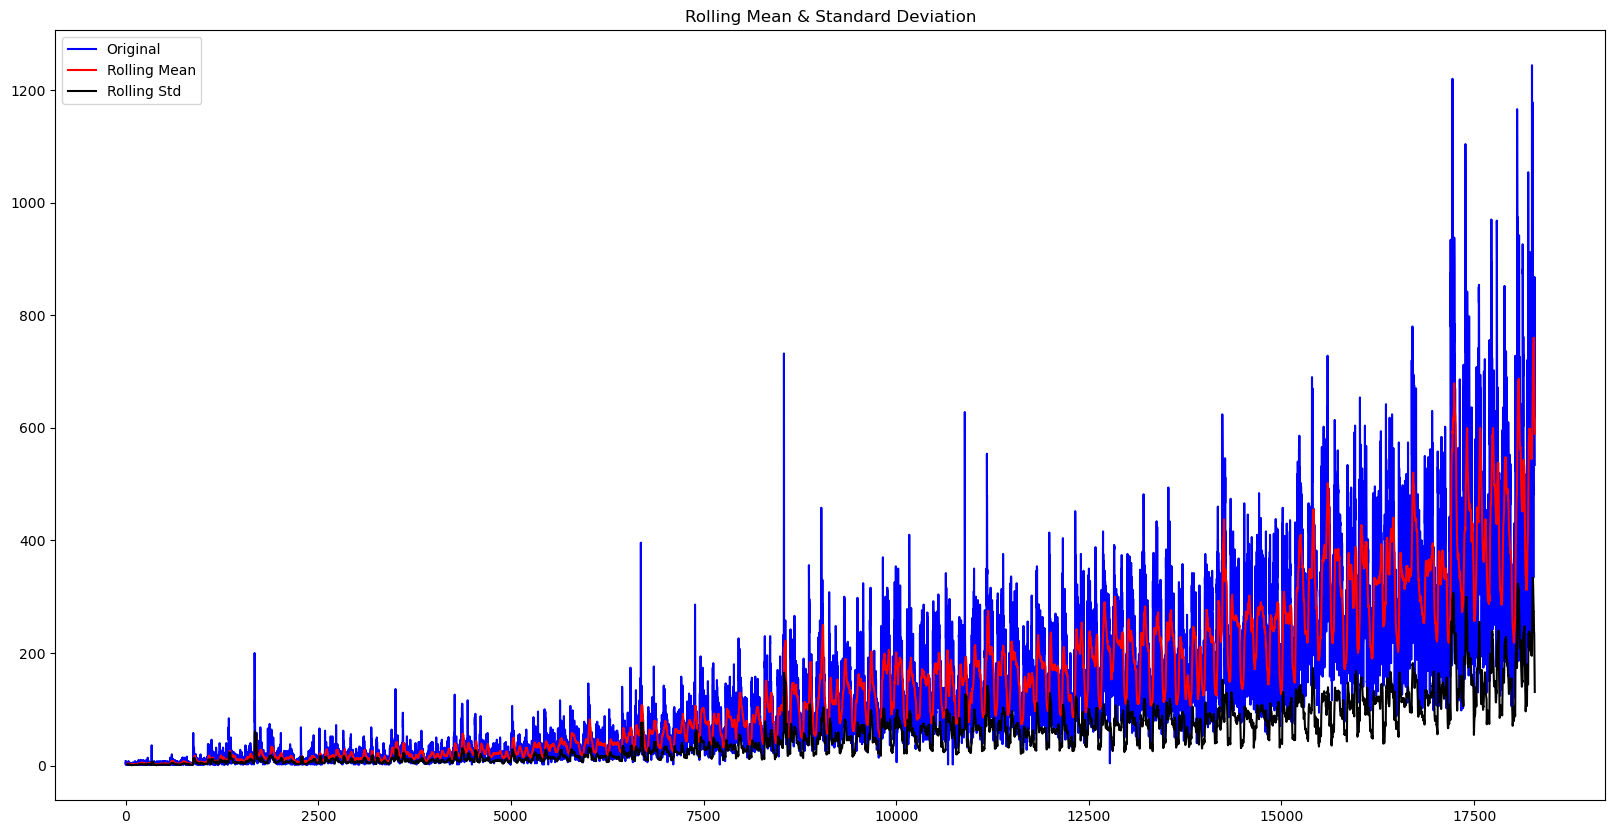

Results of Dickey-Fuller Test:
Test Statistic             -4.456561
p-value                     0.000235
#Lags Used                 45.000000
#Observations Used      18242.000000
Critical Value (1%)        -3.430709
Critical Value (5%)        -2.861698
Critical Value (10%)       -2.566854
dtype: float64


In [165]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

test_stationary(train_original['Count'], 24) # train_original contains hourly count data; 24 hours on each day

From the `Dickey-Fuller Test`, the statistics shows that **the time series is stationary** as `test statistic` < `critical value` so we can reject the null hypothesis. But we can see an increasing trend in the data. So, firstly we will try to make the data more stationary. For doing so, we need to remove the `trend` and `seasonality` from the data.

### **<span style='color:maroon'> Removing Trend** </span>
* A trend exists when there is a long-term increase or decrease in the data. It does not havve to be linear.
* We see an increasing trend in the data so we can apply transformation which penalizes higher values more than smaller ones, for example <span style='color:green'>**log transformation**</span>. 
* We will <span style='color:green'>**take rolling mean**</span> here to remove the trend. We will take the window size of 14 based on the fact that each week has 7 days.

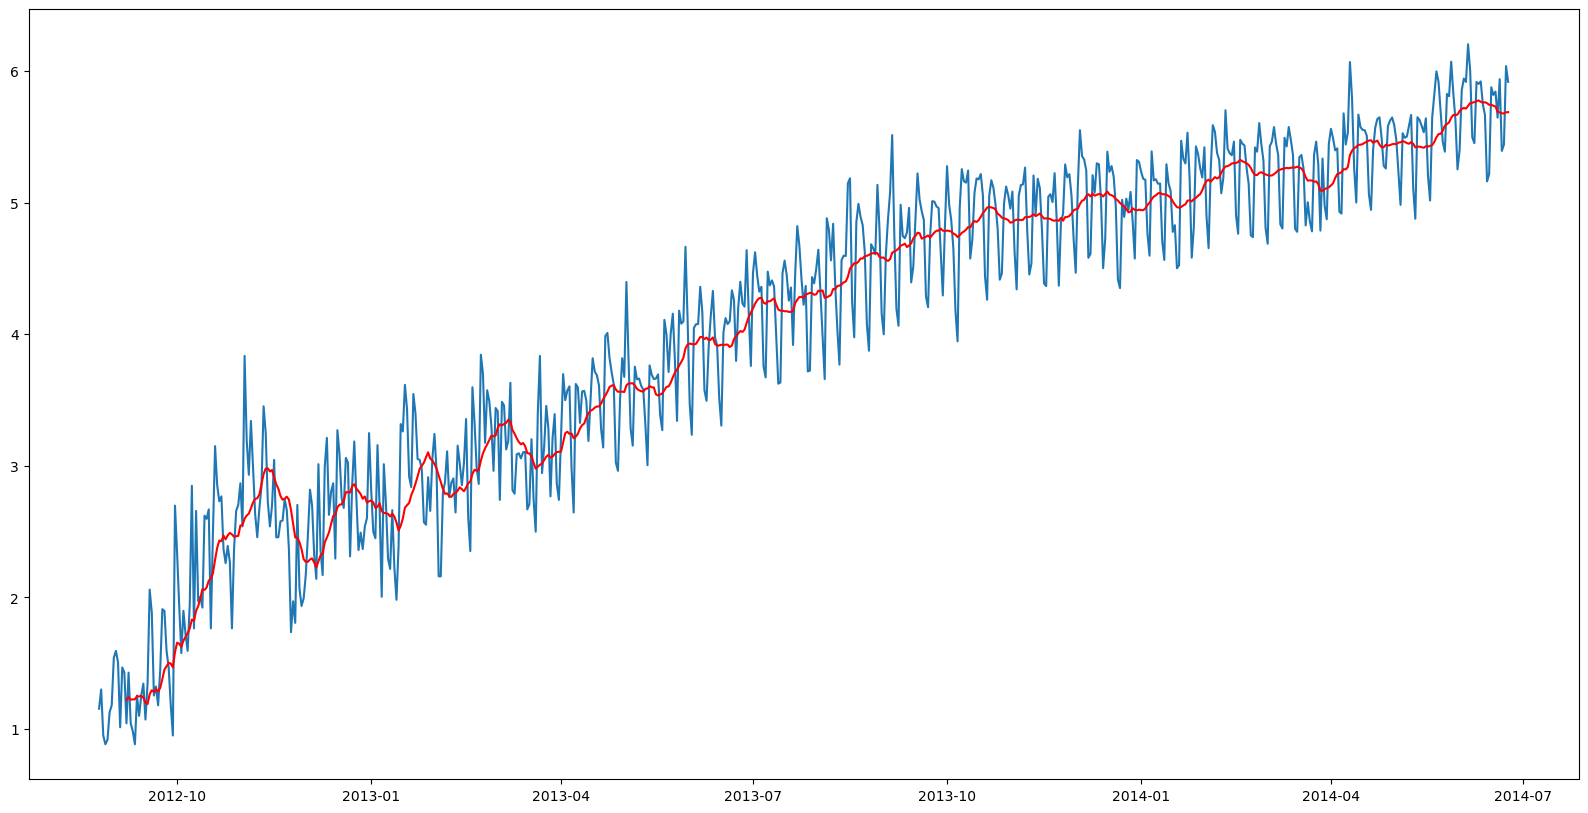

In [179]:
Train_log = np.log(Train['Count'])
Valid_log = np.log(Valid['Count'])

moving_avg = Train_log.rolling(14).mean() # Train_log contain daily counts; 7 days a week
plt.plot(Train_log)
plt.plot(moving_avg, color='red');

So we can observe an increasing trend. Now we will remove this increasing trend to make our time series stationary.

In [180]:
train_log_moving_avg_diff = Train_log - moving_avg

Since we take the average of 7 values, rolling mean is not defined for the first **6** values. So let's drop these `NaN` values.

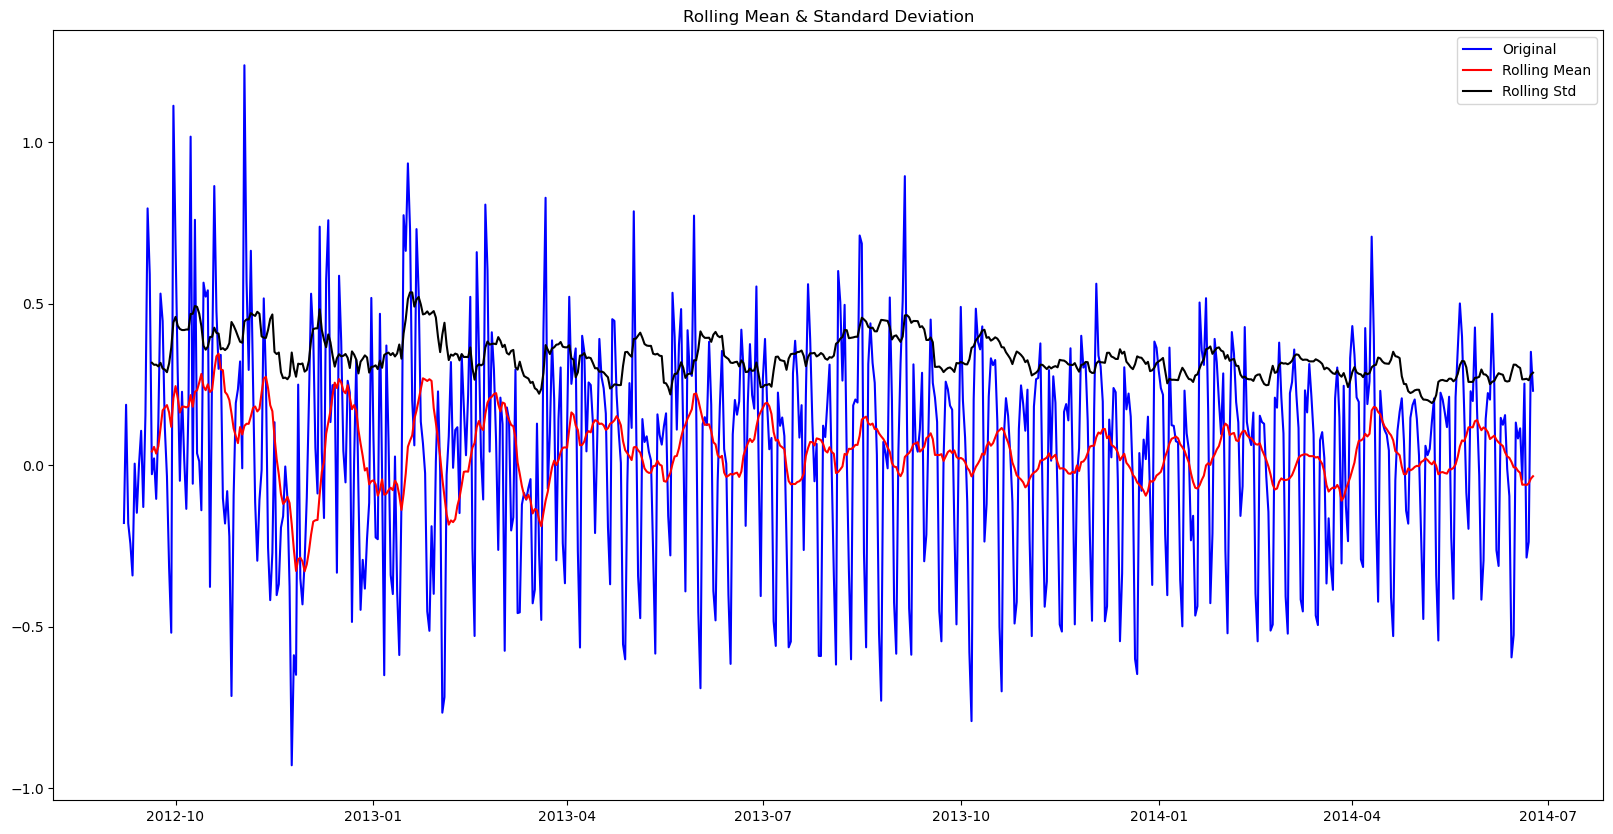

Results of Dickey-Fuller Test:
Test Statistic         -6.309769e+00
p-value                 3.256213e-08
#Lags Used              2.000000e+01
#Observations Used      6.350000e+02
Critical Value (1%)    -3.440690e+00
Critical Value (5%)    -2.866102e+00
Critical Value (10%)   -2.569200e+00
dtype: float64


In [181]:
train_log_moving_avg_diff.dropna(inplace=True)
test_stationary(train_log_moving_avg_diff, 14)

From the `Dickey-Fuller Test`, it shows that the test statistic is smaller as compared to the critical values. So we can reject the null hypothesis and conclude that the trend is removed.

Let's now **stabilize the mean** of the time series which is also a requirement for a stationary time series.
* <span style='color:green'> **Differencing**</span> can help to make the time series stable and eliminate the trend.

In [182]:
Train_log.head()

Datetime
2012-08-25    1.152680
2012-08-26    1.299283
2012-08-27    0.949081
2012-08-28    0.882389
2012-08-29    0.916291
Freq: D, Name: Count, dtype: float64

In [183]:
Train_log.shift(1).head()

Datetime
2012-08-25         NaN
2012-08-26    1.152680
2012-08-27    1.299283
2012-08-28    0.949081
2012-08-29    0.882389
Freq: D, Name: Count, dtype: float64

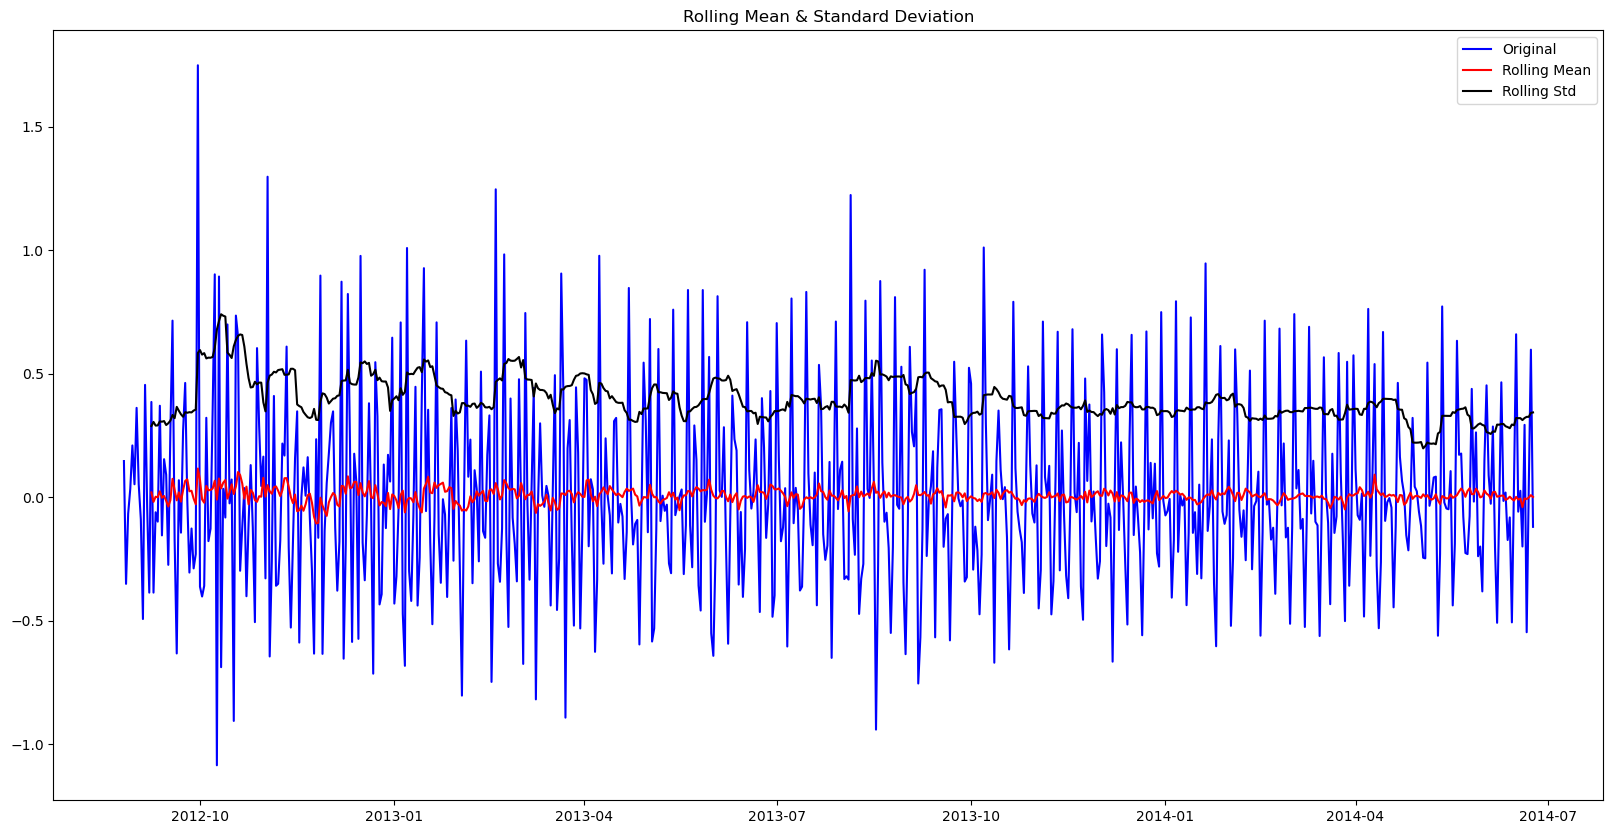

Results of Dickey-Fuller Test:
Test Statistic         -8.237568e+00
p-value                 5.834049e-13
#Lags Used              1.900000e+01
#Observations Used      6.480000e+02
Critical Value (1%)    -3.440482e+00
Critical Value (5%)    -2.866011e+00
Critical Value (10%)   -2.569151e+00
dtype: float64


In [184]:
train_log_diff = Train_log - Train_log.shift(1)
test_stationary(train_log_diff.dropna(), 14)

### **<span style='color:maroon'> Removing Seasonality** </span>
* By seasonality, we mean periodic fluctuations. A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week). 
* Seasonality is always of a fixed and known period.
* We will use `seasonal decompose` to decompose the time series into `trend`, `seasonality` and `residuals`.

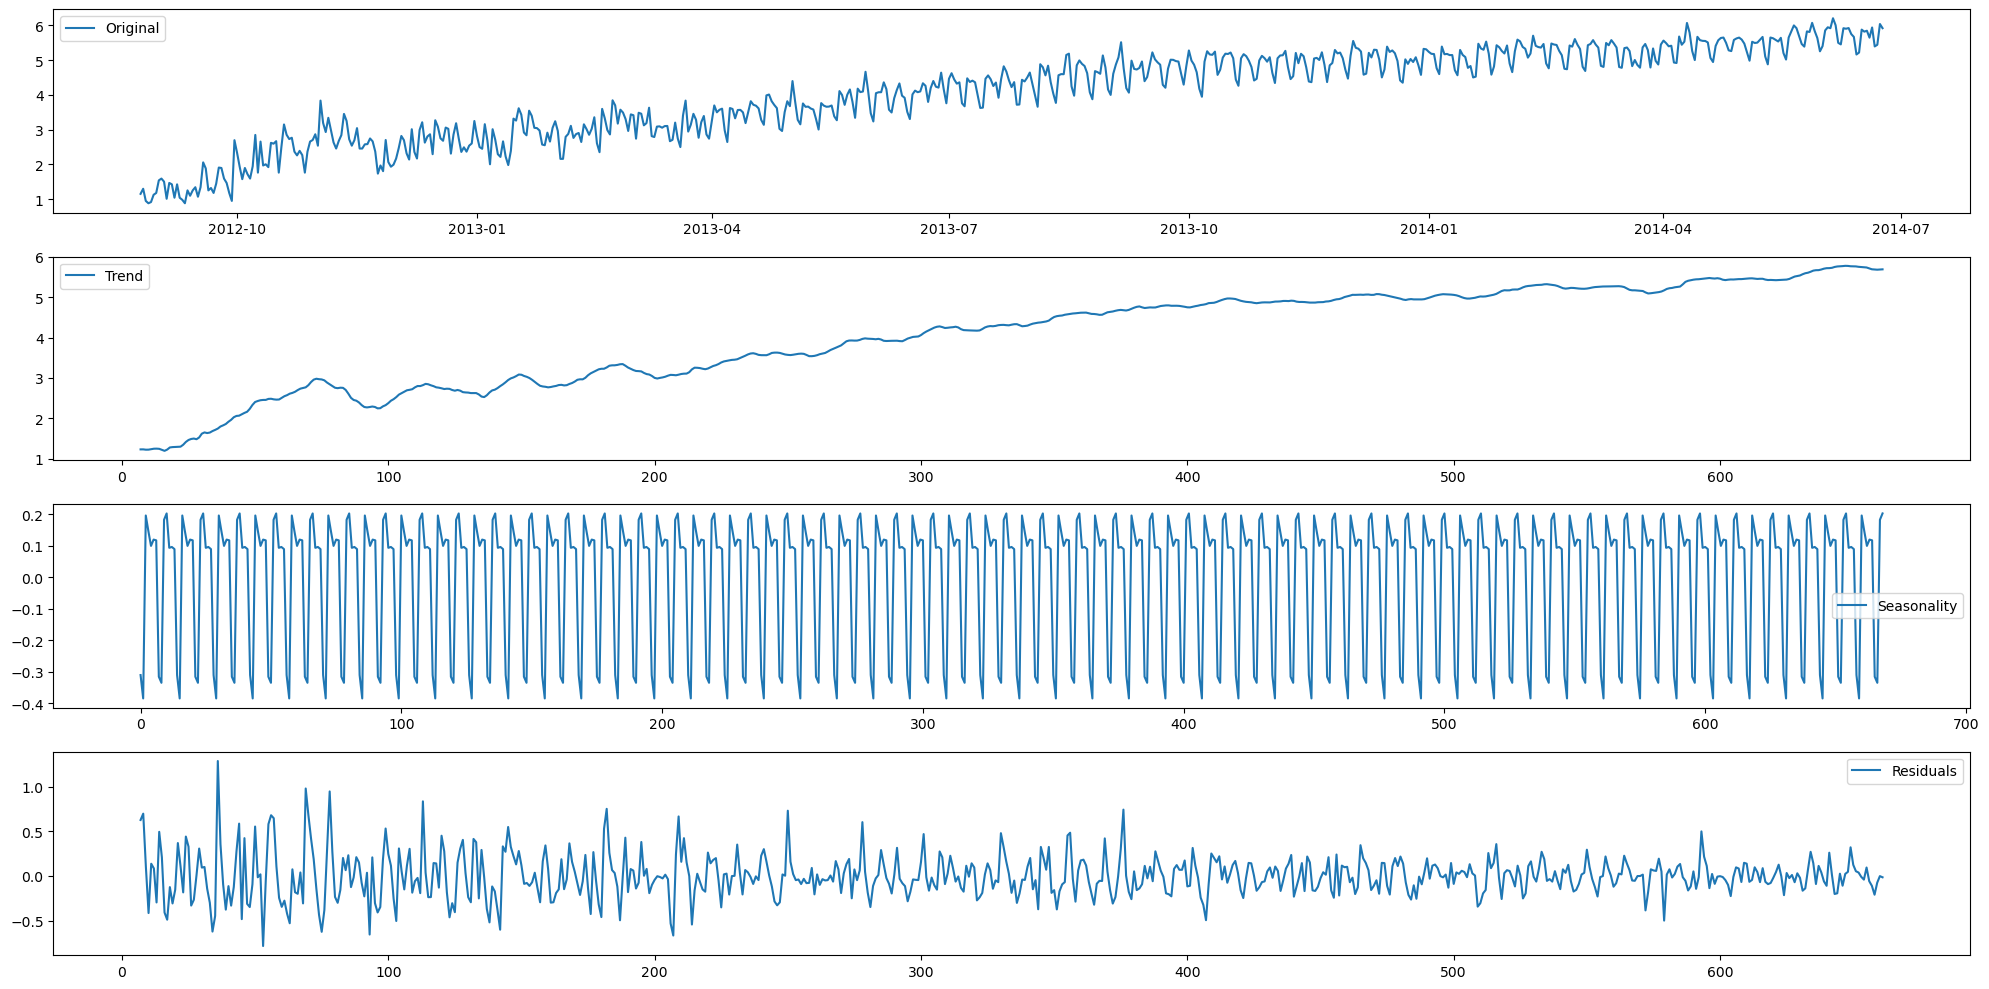

In [188]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(pd.DataFrame(Train_log)['Count'].values, period=14)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(Train_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout();

We can see the `trend`, `seasonality`, and `residuals` clearly in the above graphs. Seasonality shows a constant trend in counter.

Let's check the stationary of residuals.

In [231]:
train_log_decompose = pd.DataFrame(residual)
train_log_decompose['date'] = Train_log.index
train_log_decompose.set_index('date', inplace=True) # assign the date column as index
train_log_decompose.dropna(inplace=True) # drop NaN values
train_log_decompose.columns = ['Count'] # rename columns
train_log_decompose.head()

Count
date                
2012-09-01  0.626256
2012-09-02  0.697267
2012-09-03  0.098089
2012-09-04 -0.415751
2012-09-05  0.136376

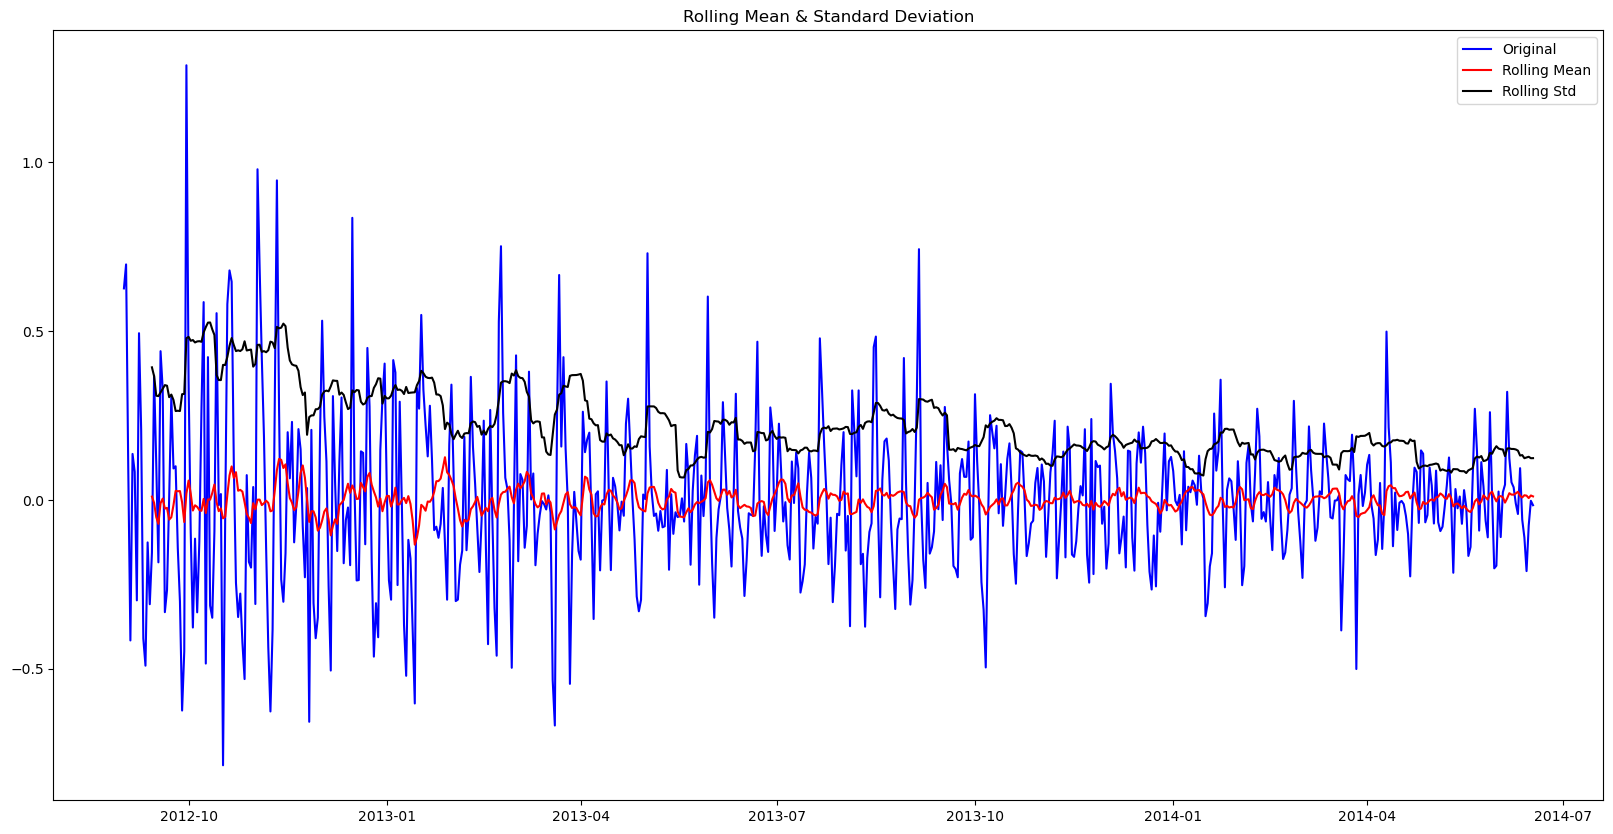

Results of Dickey-Fuller Test:
Test Statistic         -9.299069e+00
p-value                 1.125274e-15
#Lags Used              1.900000e+01
#Observations Used      6.350000e+02
Critical Value (1%)    -3.440690e+00
Critical Value (5%)    -2.866102e+00
Critical Value (10%)   -2.569200e+00
dtype: float64


In [233]:
test_stationary(train_log_decompose['Count'], 14) # note: 0 refers to the 0 columm here

It can be seen from the `Dickey-Fuller Test` that the `residuals` are stationary. Now the `residuals` can be used as input to the ARIMA model.

**Forecasting the time series using ARIMA**
* In order to fit the ARIMA model on our time series, we have to find the optimized values for the `p,d,q` parameters.
* To find the optimized values of these parameters, we will use **ACF (Autocorrelation Function)** and **PACF (Partial Autocorrelation Function**) graphs.
* ACF is a measure of the correlation between the time series with a lagged version of itself.
* PACF measures the correlation between the time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.

In [249]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(train_log_diff.dropna(), nlags=25)
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')

# lag_acf = acf(train_log_decompose, nlags=25)
# lag_pacf = pacf(train_log_decompose, nlags=25, method='ols')

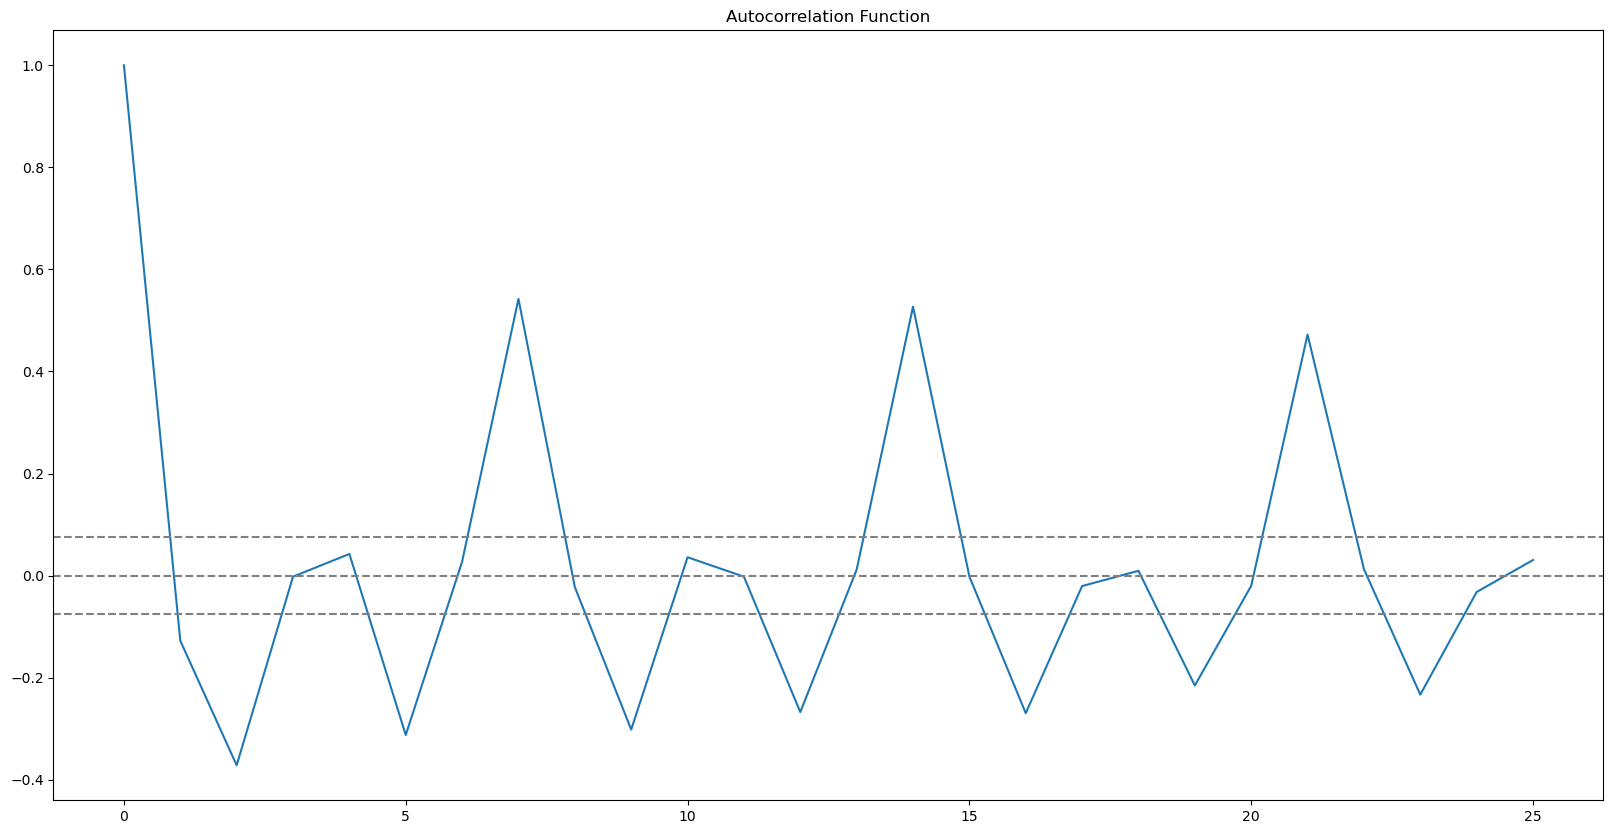

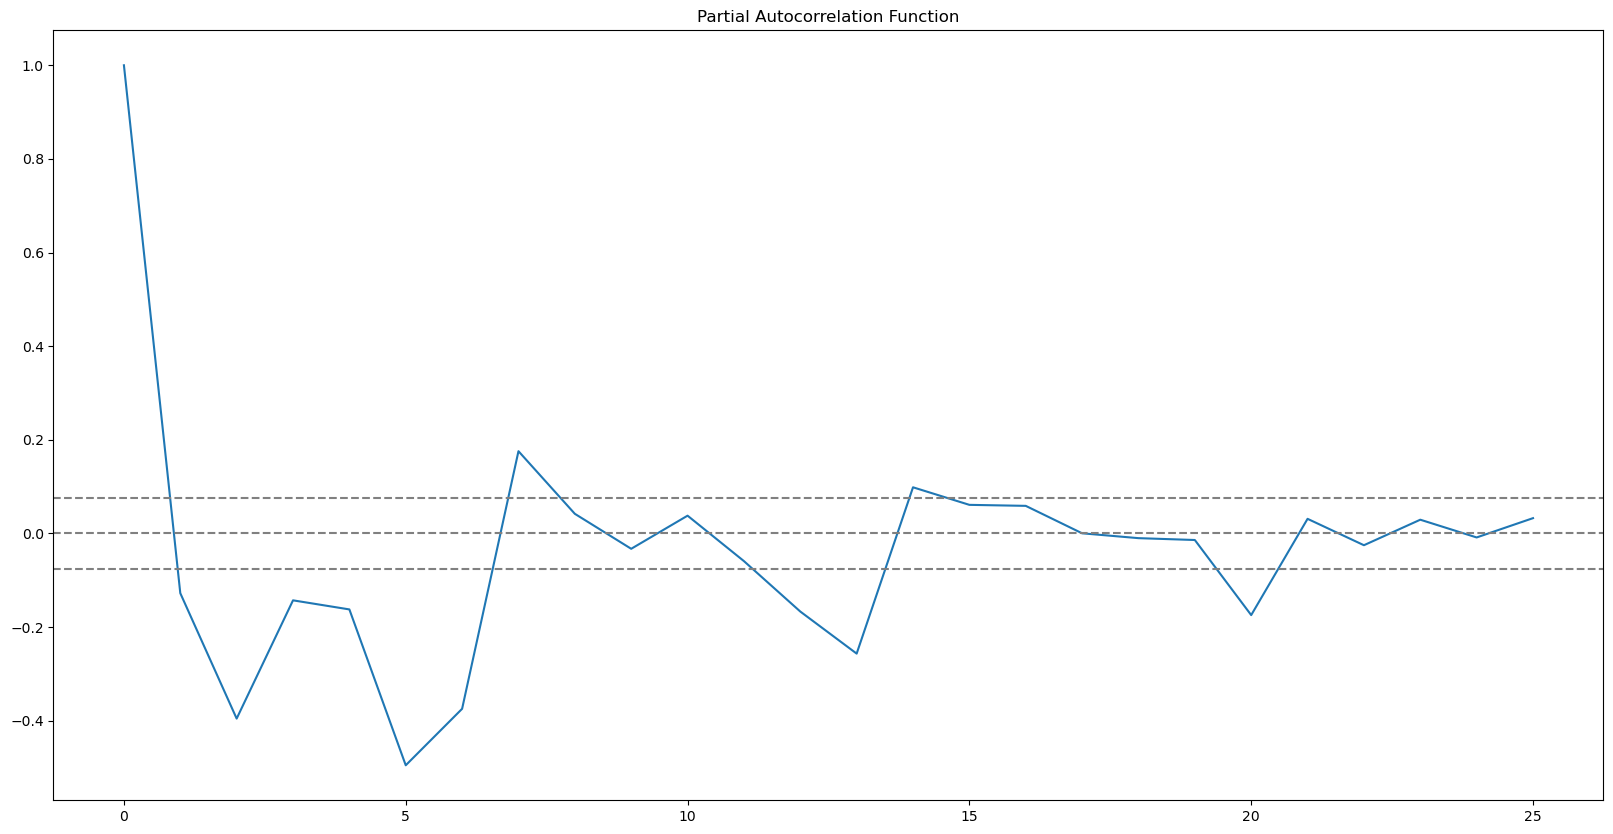

In [251]:
# ACF and PACF plots
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())), linestyle='--', color='gray') # 95% confidence interval
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())), linestyle='--', color='gray')
plt.title('Autocorrelation Function')
plt.show();

plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function');


# plt.plot(lag_acf)
# plt.axhline(y=0, linestyle='--', color='gray')
# plt.axhline(y=-1.96/np.sqrt(len(train_log_decompose)), linestyle='--', color='gray') # 95% confidence interval
# plt.axhline(y=1.96/np.sqrt(len(train_log_decompose)), linestyle='--', color='gray')
# plt.title('Autocorrelation Function')
# plt.show();

# plt.plot(lag_pacf)
# plt.axhline(y=0, linestyle='--', color='gray')
# plt.axhline(y=-1.96/np.sqrt(len(train_log_decompose)), linestyle='--', color='gray')
# plt.axhline(y=1.96/np.sqrt(len(train_log_decompose)), linestyle='--', color='gray')
# plt.title('Partial Autocorrelation Function');

* p value is the lag value where the PACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case p=2.
* q value is the lag value where the ACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case q=2.

Now we will make the ARIMA model as we have the p,q values. We will make the AR and MA models separately and then combine them together. 

**AR Model**<br>
The autoregressive model specifies that the output variable depends linearly on its own previous values.

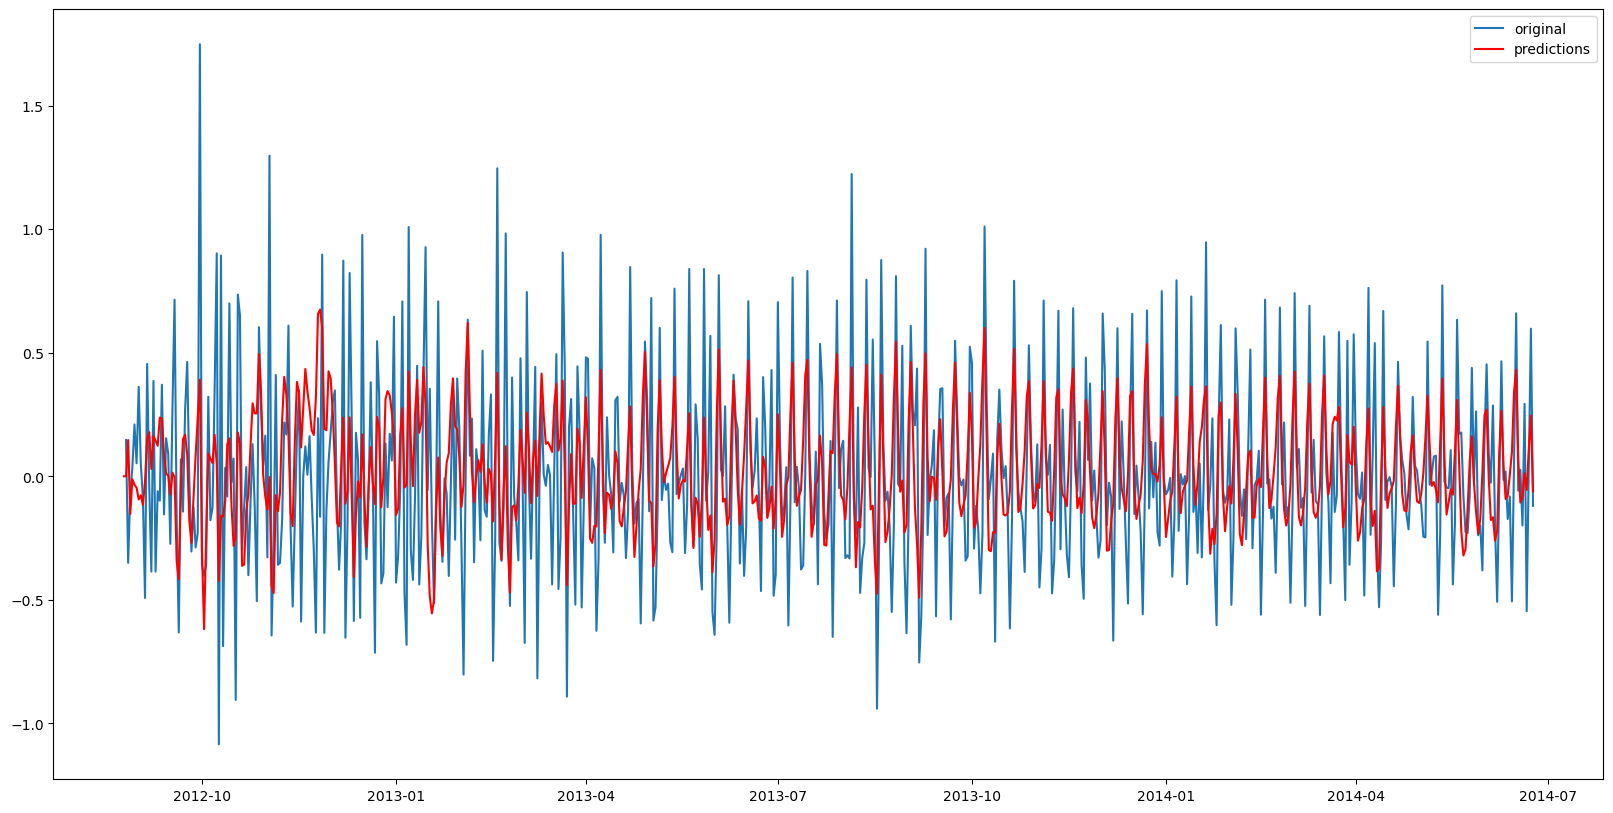

In [252]:
from statsmodels.tsa.arima.model import ARIMA

# AR model
model = ARIMA(train_log_diff, order=(2, 1, 2)) # Train_log also works
# model = ARIMA(train_log_decompose, order=(2, 1, 0)) # here the q value is zero since it is just the AR model
results_AR = model.fit()
plt.plot(train_log_diff.dropna(), label='original')
# plt.plot(train_log_decompose, label='original')
plt.plot(results_AR.fittedvalues, color='red', label='predictions')
plt.legend(loc='best');

Let's plot the validation curve for the AR model. <br>
We have to change the scale of the model to the original scale.
First step would be to store the predicted results as a separate series and observe it.

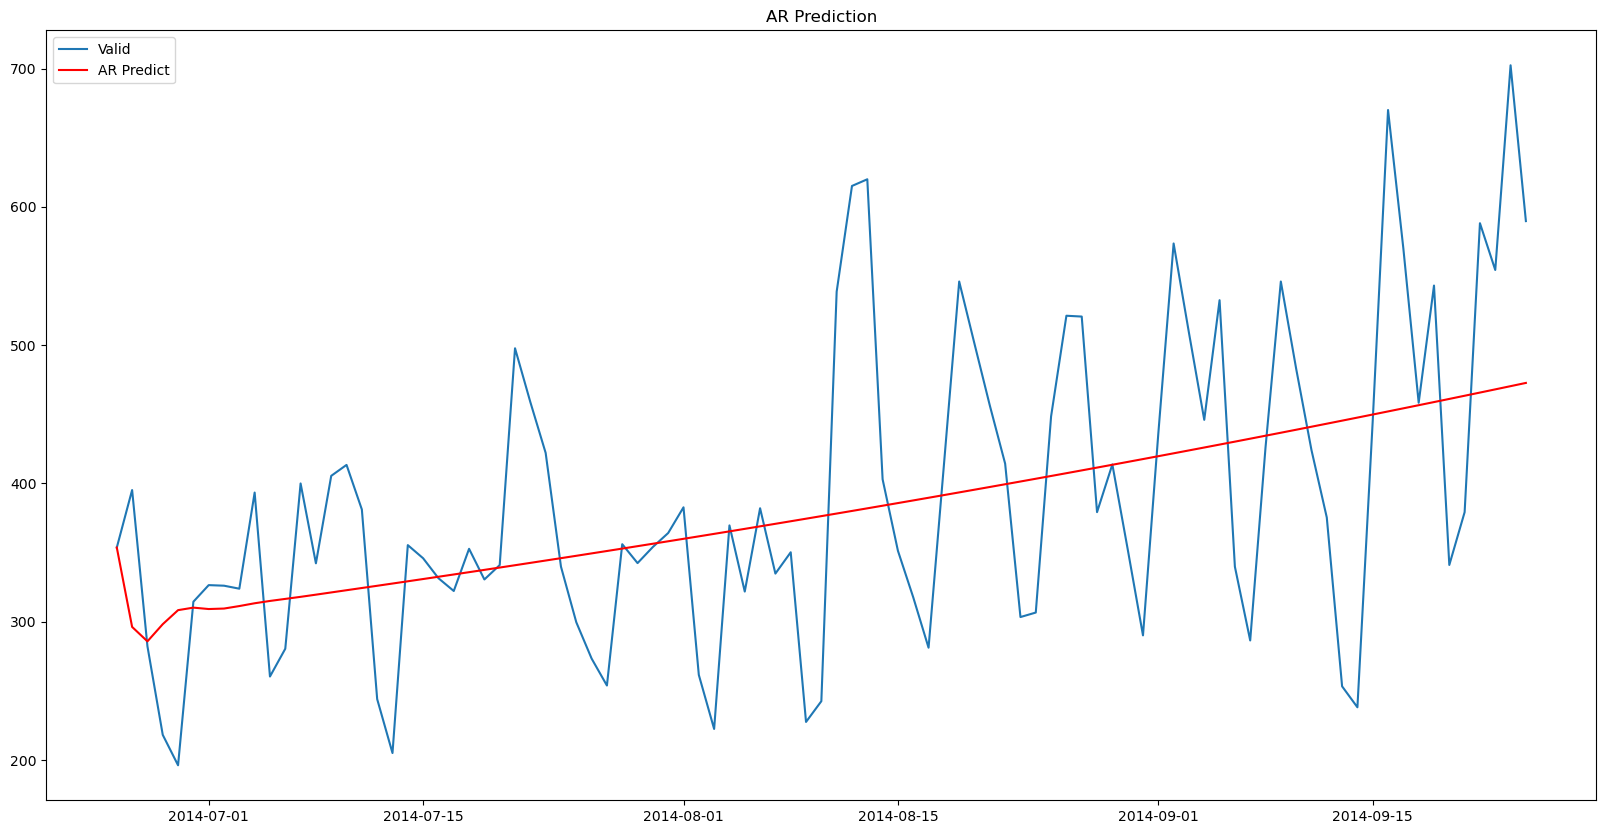

In [253]:
AR_predict = results_AR.predict(start='2014-06-25', end='2014-09-25')
AR_predict = AR_predict.cumsum().shift().fillna(0) # shift() have lag 1 by default
# cumsum() is applied to compensate for the differencing performed
AR_predict1 = pd.Series(np.ones(Valid.shape[0]) * np.log(Valid['Count'])[0], index=Valid.index)
AR_predict1 = AR_predict1.add(AR_predict, fill_value=0)
AR_predict = np.exp(AR_predict1)

plt.plot(Valid['Count'], label='Valid')
plt.plot(AR_predict, color='red', label='AR Predict')
plt.legend(loc='best')
plt.title('AR Prediction');

In [254]:
RMSE_AR = np.sqrt(mean_squared_error(Valid['Count'], AR_predict))
print(f'The performance of AR Model is: RMSE={RMSE_AR}')

The performance of AR Model is: RMSE=94.86876202436144


Here the red line shows the prediction for the validation set. Let's build the MA model now.

**MA Model** <br>
The moving-average model specifies that the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term.

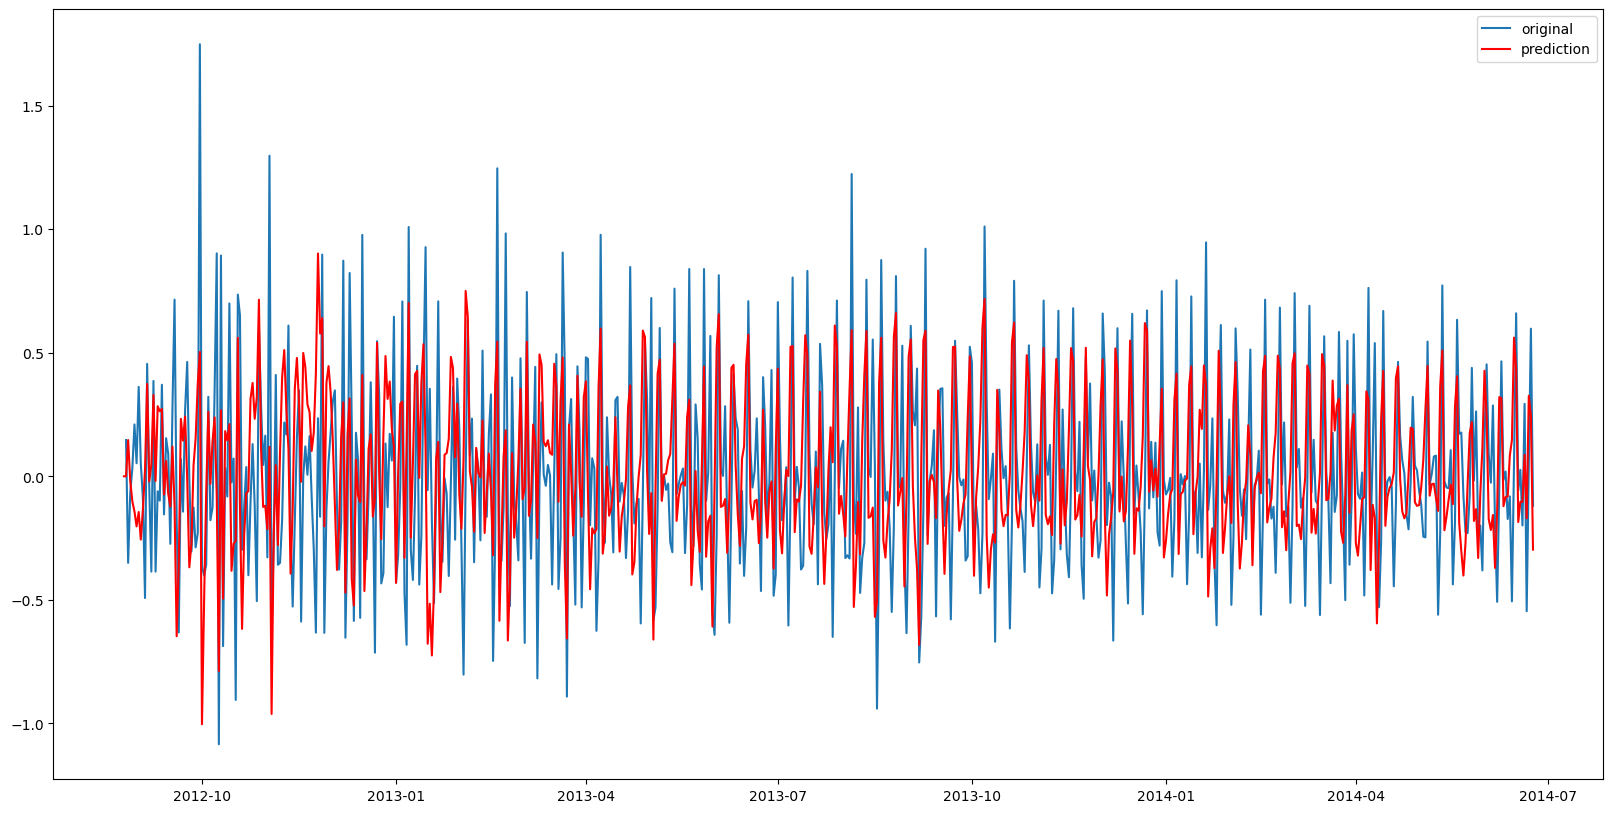

In [255]:
model = ARIMA(train_log_diff, order=(0, 1, 2)) # here the p value is zero since it is just the MA model
# model = ARIMA(train_log_decompose, order=(0, 1, 2)) # here the p value is zero since it is just the MA model
results_MA = model.fit()
plt.plot(train_log_diff.dropna(), label='original')
# plt.plot(train_log_decompose, label='original')
plt.plot(results_MA.fittedvalues, color='red', label='prediction')
plt.legend(loc='best');

Let's plot the validation curve for the MA model. 

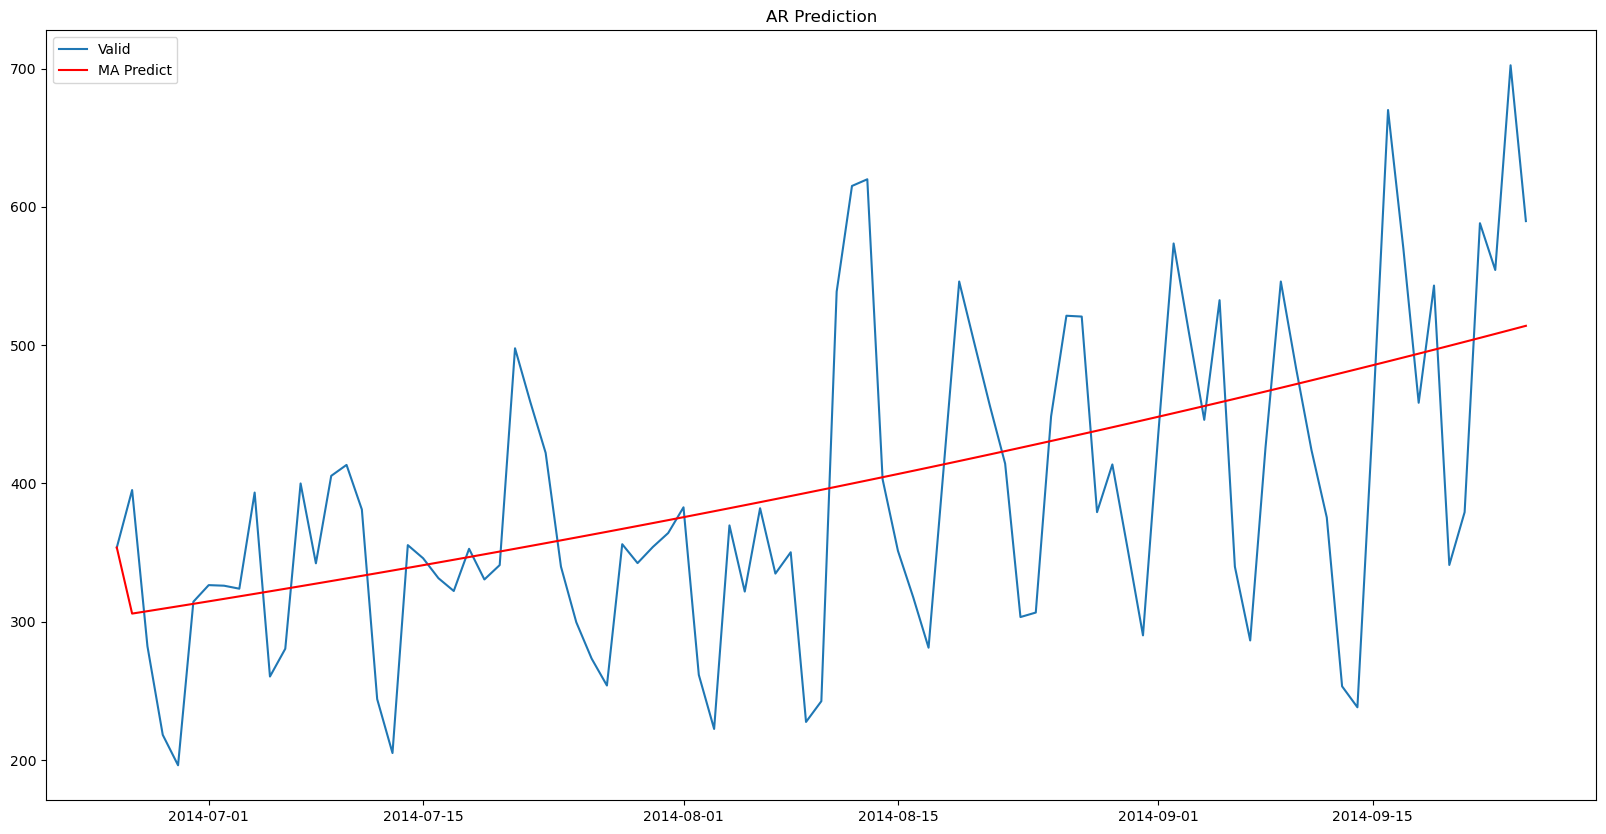

In [256]:
MA_predict = results_MA.predict(start='2014-06-25', end='2014-09-25')
MA_predict = MA_predict.cumsum().shift().fillna(0) # shift() have lag 1 by default
# cumsum() is applied to compensate for the differencing performed
MA_predict1 = pd.Series(np.ones(Valid.shape[0]) * np.log(Valid['Count'])[0], index=Valid.index)
MA_predict1 = MA_predict1.add(MA_predict, fill_value=0)
MA_predict = np.exp(MA_predict1)

plt.plot(Valid['Count'], label='Valid')
plt.plot(MA_predict, color='red', label='MA Predict')
plt.legend(loc='best')
plt.title('AR Prediction');

In [257]:
RMSE_MA = np.sqrt(mean_squared_error(Valid['Count'], MA_predict))
print(f'The performance of MA Model is: RMSE={RMSE_MA}')

The performance of MA Model is: RMSE=94.74774236546048


Now let's combine these two models.

**Combined Model**

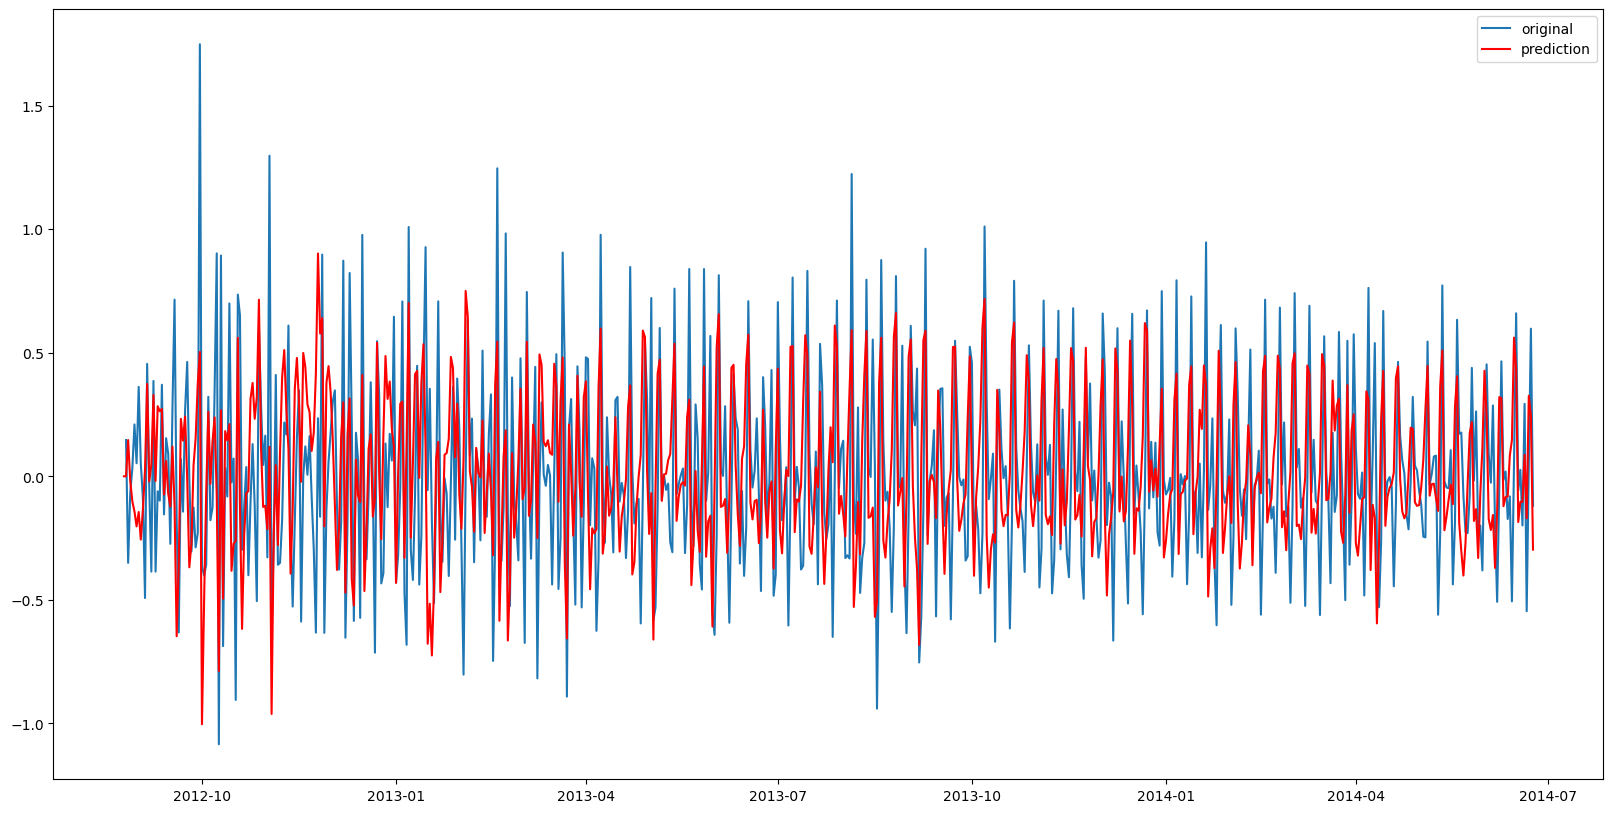

In [258]:
# model = ARIMA(train_log_decompose, order=(2, 1, 2)) # Train_log also works
model = ARIMA(train_log_diff, order=(2, 1, 2)) # Train_log also works
results_ARIMA = model.fit()
# plt.plot(train_log_decompose, label='original')
plt.plot(train_log_diff.dropna(), label='original')
plt.plot(results_MA.fittedvalues, color='red', label='prediction')
plt.legend(loc='best');

In [259]:
# Define a function which can be used to change the scale of the model to the original scale
def check_prediction_diff(predict_diff, given_set):
    predict_diff = predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0], index=given_set.index)
    predict_log = predict_base.add(predict_diff, fill_value=0)
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Count'], label='Given set')
    plt.plot(predict, color='red', label='Predict')
    plt.legend(loc='best')
    plt.title('ARIMA Prediction');

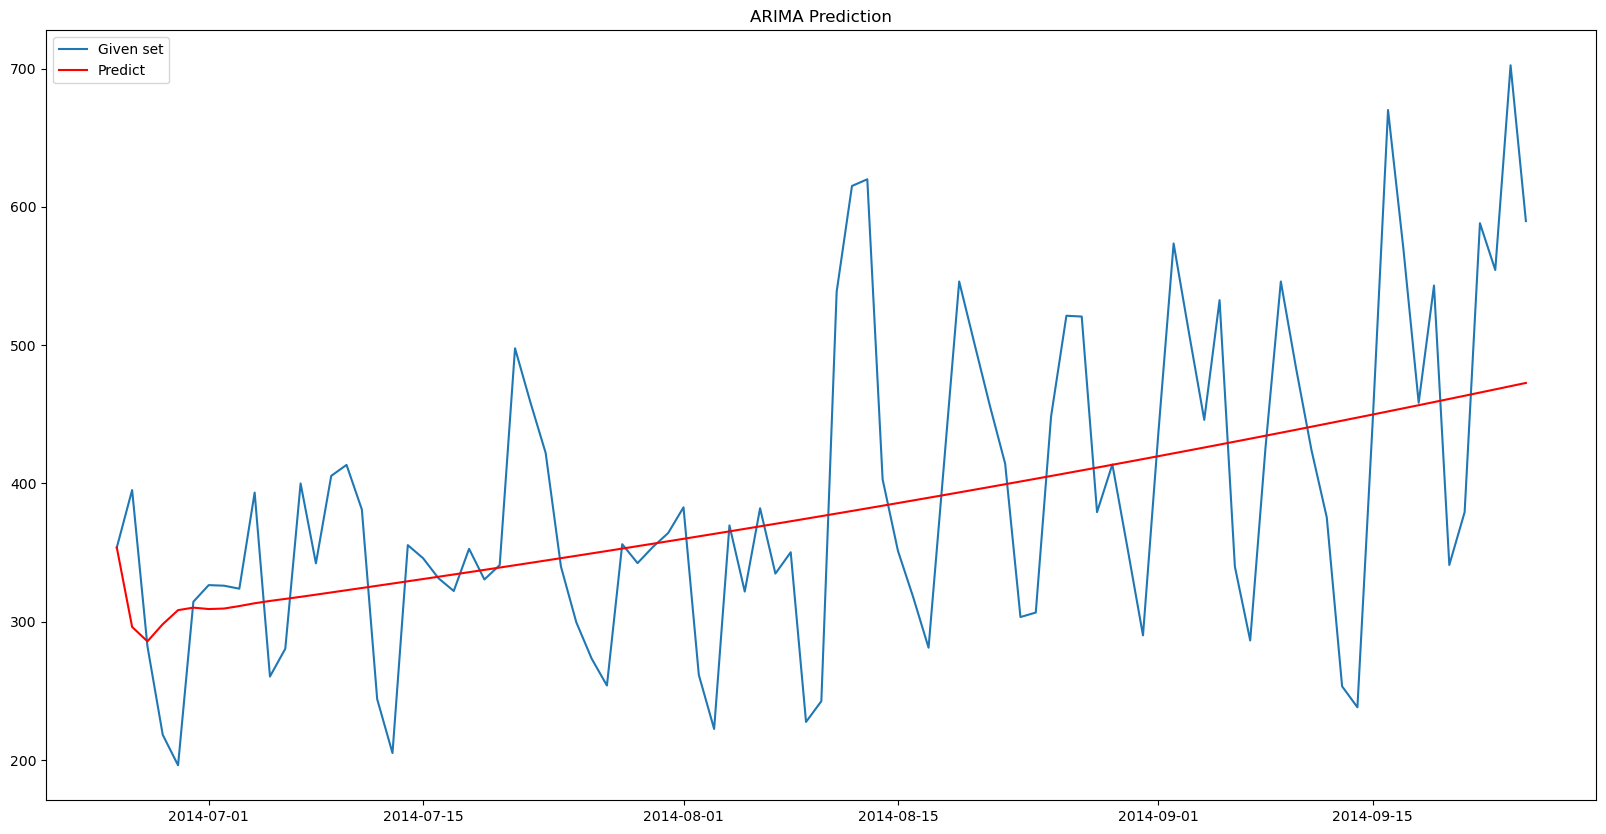

In [260]:
# Predict values on the validation set
ARIMA_predict_diff = results_ARIMA.predict(start='2014-06-25', end='2014-09-25')
check_prediction_diff(ARIMA_predict_diff, Valid)

In [262]:
RMSE_ARIMA = np.sqrt(mean_squared_error(Valid['Count'], ARIMA_predict_diff))
print(f'The performance of ARIMA Model is: RMSE={RMSE_ARIMA}')

The performance of ARIMA Model is: RMSE=404.6633529595311


#### <span style='color:blue'> (7) SARIMAX Model on daily time series </span>
SARIMAX model takes into account the seasonality of the time series.  

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.59397D+00    |proj g|=  6.76341D-02

At iterate    5    f=  4.56367D+00    |proj g|=  1.38791D-02


 This problem is unconstrained.



At iterate   10    f=  4.51060D+00    |proj g|=  6.26802D-02

At iterate   15    f=  4.49967D+00    |proj g|=  2.46044D-03

At iterate   20    f=  4.49393D+00    |proj g|=  1.92478D-02

At iterate   25    f=  4.49182D+00    |proj g|=  1.41357D-02

At iterate   30    f=  4.49126D+00    |proj g|=  3.60867D-03

At iterate   35    f=  4.49124D+00    |proj g|=  2.44734D-04

At iterate   40    f=  4.49123D+00    |proj g|=  4.95319D-04

At iterate   45    f=  4.49109D+00    |proj g|=  1.23459D-03

At iterate   50    f=  4.49089D+00    |proj g|=  2.41484D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61   

/Users/ivy/opt/miniconda3/envs/ml_mac/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


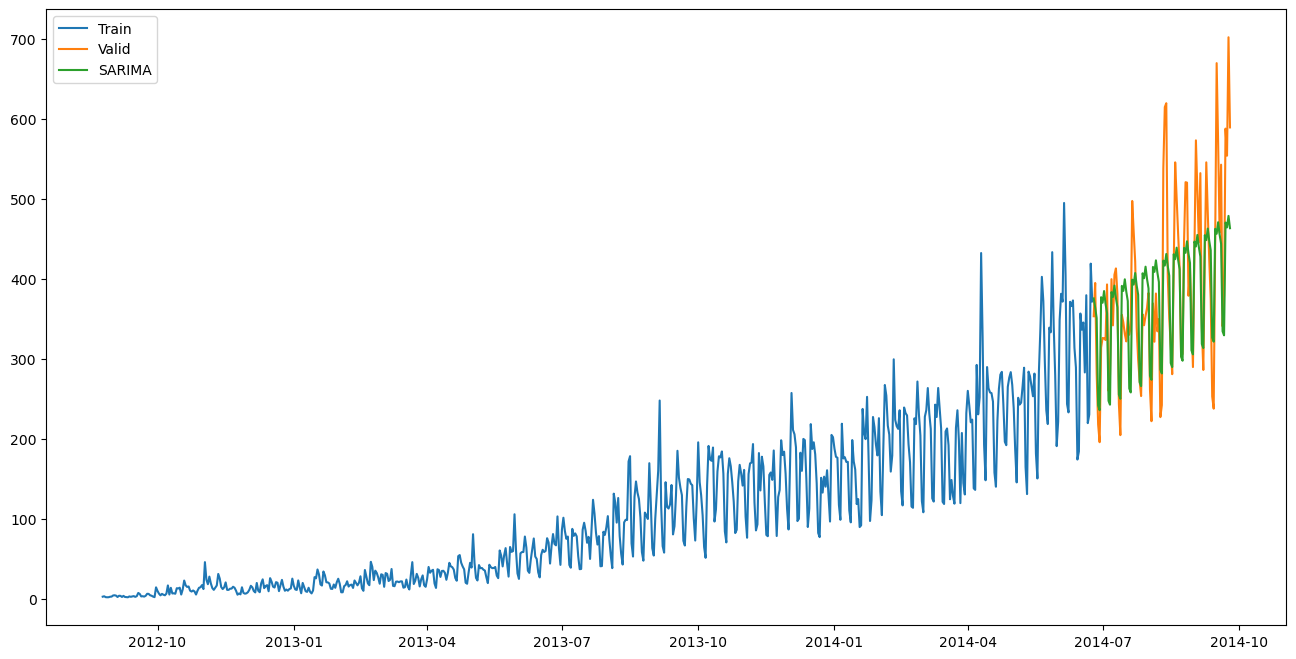

In [267]:
import statsmodels.api as sm
y_hat_avg = Valid.copy()
SARIMA = sm.tsa.statespace.SARIMAX(Train['Count'], order=(2, 1, 4), seasonal_order=(0, 1, 1, 7)).fit()
y_hat_avg['SARIMA'] = SARIMA.predict(start='2014-06-25', end='2014-9-25', dynamic=True)

plt.figure(figsize=(16, 8))
plt.plot(Train['Count'], label='Train')
plt.plot(Valid['Count'], label='Valid')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best');

* `Order` in the above model represents the order of the autoregressive model (number of time lags), the degress of differencing (number of times the data have had past values substracted), and the order of moving average model.
* `Seasonal order` represents the order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity.
* In our case the periodicity is 7 since it is daily time series and will repeat after every 7 days.

Let's check the RMSE value on the validation dataset.

In [268]:
RMSE_SARIMA = np.sqrt(mean_squared_error(Valid['Count'], y_hat_avg['SARIMA']))
print(f'The performance of SARIMAX Model is: RMSE={RMSE_SARIMA}')

The performance of SARIMAX Model is: RMSE=70.18817531405243


Now we will forecast the time series for test dataset which starts from 2014-9-26 and ends at 2015-4-26.

In [271]:
predict_SARIMAX = SARIMA.predict(start='2014-9-26', end='2015-4-26', dynamic=True)

/Users/ivy/opt/miniconda3/envs/ml_mac/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Note that these are the daily predictions and we need hourly predictions. So, we will distribute this daily prediction into hourly counts. To do so, we will take the ratio of hourly distribution of passenger count from training dataset and then we will distribute the predictions in the same ratio.

In [273]:
test['prediction_SARIMAX'] = predict_SARIMAX

# Merge test and test_original on day, month and year
merge = pd.merge(test, test_original, on=('day', 'month', 'year'), how='left')
merge['Hour'] = merge['Hour_y']
merge = merge.drop(['year', 'month', 'Datetime', 'Hour_x', 'Hour_y'], axis=1)

# Predict by merging merge and temp
prediction_SARIMAX = pd.merge(merge, temp, on='Hour', how='left')

# Convert the ratio to the original scale
prediction_SARIMAX['Count'] = prediction_SARIMAX['prediction_SARIMAX'] * prediction_SARIMAX['ratio']*24

# Drop all variables other than ID and and Count
prediction_SARIMAX['ID'] = prediction_SARIMAX['ID_y']
submission = prediction_SARIMAX.drop(['day', 'Hour', 'ratio', 'prediction_SARIMAX', 'ID_x', 'ID_y'], axis=1)

# Convert the final submission to csv format
pd.DataFrame(submission, columns=['ID', 'Count']).to_csv('SARIMAX.csv')

## Further Improvements
* Make a weekly time series and make predictions for that series and then distribute those predictions into daily and then hourly predictions.
* Use combination of models (`ensemble`) to reduce the RMSE. 

Other references on time series forecasting:
* https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/
* https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
* https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/